In [1]:
!pip install datasets
!pip install optuna
!pip install scikit-multilearn
!pip install PyEvALL

import pandas as pd
import logging
from datasets import Dataset
import os
import optuna
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from transformers import set_seed
import torch
from torch.utils.data import Dataset, DataLoader
import random

# Import the drive library
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('drive/MyDrive/Colab/thesis/models')
from utils_classification import *

Mounted at /content/drive/


In [2]:
seed = 0
set_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
dir = "/content/drive/MyDrive/Colab/thesis"

In [4]:
class DataLoader:
    def __init__(self, tokenizer, device='cpu', max_length=512):
        """
        Initialize the data loader.

        Parameters:
        - tokenizer: Hugging Face tokenizer.
        - device (str): Device to load the tensors onto.
        - max_length (int): Max sequence length for padding/truncation.
        """
        self.tokenizer = tokenizer
        self.device = device
        self.max_length = max_length

    def tokenize(self, texts):
        """
        Tokenize a list of text samples.

        Parameters:
        - texts (list): List of strings.

        Return:
        - dict: Tokenized inputs as tensors on the specified device.
        """
        tokenized = self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        ).to(self.device)

        return tokenized

    def load(self, data, labels=None):
        """
        Load and return a Hugging Face Dataset object.

        Parameters:
        - data (list): List of input texts.
        - labels (list, optional): Labels corresponding to the input texts.

        Return:
        - Dataset: Hugging Face Dataset object with tokenized inputs.
        """
        tokenized = self.tokenize(data)

        if labels is not None:
            tokenized = {**tokenized, 'labels': torch.tensor(labels).to(self.device)}

        dataset_dict = {k: v.cpu() for k, v in tokenized.items()}
        hf_dataset = Dataset.from_dict(dataset_dict)

        return hf_dataset

# MAMI

In [ ]:
ds_name = "MAMI"
mami_training_data = "".join([dir, "/data/MAMI/MAMI_training.json"])
mami_val_data = "".join([dir,"/data/MAMI/MAMI_validation.json"])
mami_test_data = "".join([dir, "/data/MAMI/MAMI_test.json"])

In [ ]:
mami_train_df = pd.read_json(mami_training_data,orient='index')
mami_dev_df = pd.read_json(mami_val_data,orient='index')
mami_test_df = pd.read_json(mami_test_data,orient='index')

In [ ]:
#get representation for RoBERTa:
#lowercase text input for roberta
mami_train_df["roberta representation"] = mami_train_df["meme text"].str.lower() + " </s> " + mami_train_df["meme caption"].str.lower()
mami_dev_df["roberta representation"] = mami_dev_df["meme text"].str.lower() + " </s> " + mami_dev_df["meme caption"].str.lower()
mami_test_df["roberta representation"] = mami_test_df["meme text"].str.lower() + " </s> " + mami_test_df["meme caption"].str.lower()

## Binary Classification: Misogynous vs. non-misogynous

In [ ]:
evaluation_type = "binary"
#division and processing of data as input to the model
X_train = mami_train_df["roberta representation"].tolist()
y_train = mami_train_df['misogynous'].tolist()
X_dev = mami_dev_df["roberta representation"].tolist()
y_dev = mami_dev_df['misogynous'].tolist()
X_test = mami_test_df["roberta representation"].tolist()
y_test = mami_test_df['misogynous'].tolist()

In [ ]:
#now let's fine-tune RoBERTa for misogyny identification

In [ ]:
#load roberta model and tokenizer
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)
#tokenize data and format as dataset dict for fine-tuning
train_data = data_loader.load(X_train, y_train)
dev_data = data_loader.load(X_dev, y_dev)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
###hyperparameter tuning with Optuna as seen at https://python-bloggers.com/2022/08/hyperparameter-tuning-a-transformer-with-optuna/

task = "misogyny-identification"
model_name = "roberta-base"

# Project constants
LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
MIN_EPOCHS = 2
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 3
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
NAME_OF_MODEL = model_name
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=SAVE_DIR,
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
        #disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
print('Triggering Optuna study')
study = optuna.create_study(study_name='hp-search-roberta', direction='minimize')
study.optimize(objective, n_trials=NUM_TRIALS)

# This can be used to train the final model. Passed through using kwargs into the model
print('Finding study best parameters')
best_lr = float(study.best_params['learning_rate'])
best_weight_decay = float(study.best_params['weight_decay'])
best_epoch = int(study.best_params['num_train_epochs'])
best_batch_size = int(study.best_params['batch_size'])

print('Extract best study params')
print(f'The best learning rate is: {best_lr}')
print(f'The best weight decay is: {best_weight_decay}')
print(f'The best epoch is : {best_epoch}')
print(f'The best batch size is: {best_batch_size}')


[I 2025-04-24 21:18:11,712] A new study created in memory with name: hp-search-roberta


Triggering Optuna study


Step,Training Loss
500,0.529500
1000,0.487600
1500,0.465800
2000,0.473900
2500,0.556100
3000,0.522100
3500,0.447700


[I 2025-04-24 21:39:06,543] Trial 0 finished with value: 0.4907300126821793 and parameters: {'batch_size': 16, 'learning_rate': 8.245683619434754e-05, 'weight_decay': 9.782897843680574e-05, 'num_train_epochs': 7}. Best is trial 0 with value: 0.4907300126821793.


Step,Training Loss
500,0.383300
1000,0.343300


[I 2025-04-24 22:01:05,366] Trial 1 finished with value: 0.3592258987697304 and parameters: {'batch_size': 64, 'learning_rate': 1.7699749009315055e-05, 'weight_decay': 0.008714450725650611, 'num_train_epochs': 8}. Best is trial 1 with value: 0.3592258987697304.


Step,Training Loss
500,0.311900


[I 2025-04-24 22:20:18,960] Trial 2 finished with value: 0.27903945443598815 and parameters: {'batch_size': 64, 'learning_rate': 3.0990047140989815e-05, 'weight_decay': 0.00027758747972849725, 'num_train_epochs': 7}. Best is trial 2 with value: 0.27903945443598815.


Finding study best parameters
Extract best study params
The best learning rate is: 3.0990047140989815e-05
The best weight decay is: 0.00027758747972849725
The best epoch is : 7
The best batch size is: 64


In [ ]:
#after doing hpt on MAMI dataset
lr = 3.0990047140989815e-05
wd = 0.00027758747972849725
epoch = 7
batch_size = 64

task = "misogyny-identification"
model_name = "roberta-base"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"

print('Training the model on the custom parameters')

args = TrainingArguments(
        output_dir=SAVE_DIR,
        eval_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=wd,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
    )

trainer = Trainer(
        model,
        args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )
result = trainer.train()

Training the model on the custom parameters


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.392732,0.828788,0.825608,0.826172
2,No log,0.405408,0.831763,0.830022,0.830449
3,No log,0.383321,0.840401,0.835212,0.835923
4,0.313200,0.454364,0.834794,0.835047,0.834880
5,0.313200,0.515997,0.836239,0.835334,0.835621
6,0.313200,0.597472,0.841060,0.838930,0.839422
7,0.313200,0.692802,0.835515,0.834162,0.834535


In [ ]:
trainer.evaluate()

{'eval_loss': 0.6928024888038635,
 'eval_precision': 0.8355153113741636,
 'eval_recall': 0.8341622916091,
 'eval_f1': 0.8345352094032137,
 'eval_runtime': 6.1599,
 'eval_samples_per_second': 162.34,
 'eval_steps_per_second': 2.597,
 'epoch': 7.0}

In [ ]:
model_dir = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
tokenizer.save_pretrained(model_dir+"/tokenizer")
model.save_pretrained(model_dir+"/model")

In [ ]:
# testing fine-tuned model for misogyny identification

In [ ]:
#loading fine-tuned model and tokenizer
evaluation_type = "binary"
task = "misogyny-identification"
model_name = "roberta-base"
model_dir = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
misogyny_id_model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
misogyny_id_tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
misogyny_id_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
#make predictions on test data
y_pred = mami_test_df["roberta representation"].apply(lambda x: classify_text(x, misogyny_id_model, misogyny_id_tokenizer, device))

Saved MAMI test split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/MAMI/roberta_MAMI_test_binary.json
Saved MAMI test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/MAMI/roberta_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for RoBERTa:
                precision    recall  f1-score   support

non-mysogynous       0.84      0.55      0.66       500
    misogynous       0.66      0.89      0.76       500

      accuracy                           0.72      1000
     macro avg       0.75      0.72      0.71      1000
  weighted avg       0.75      0.72      0.71      1000

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Confusion matrix for RoBERTa:


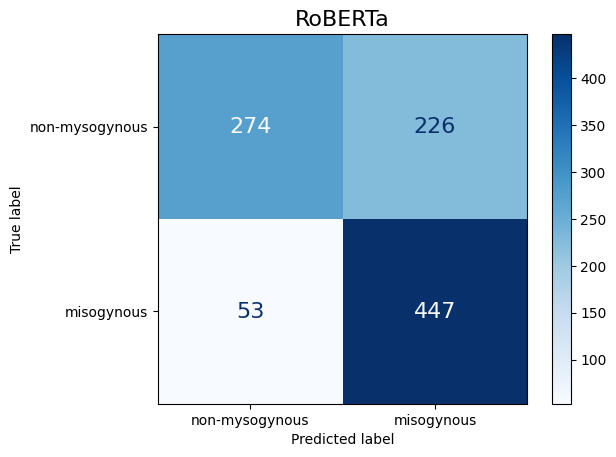

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for RoBERTa:

2025-06-24 14:48:59,944 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-06-24 14:49:00,063 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:49:00,511 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-06-24 14:49:00,515 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:49:00,919 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:49:01,337 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
cargado 29
This is a table Py

In [ ]:
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "roberta", y_pred, "misogynous", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred,
                                ["non-mysogynous","misogynous"],
                               gold_test_txt,test_pred_txt,
                               model_name="RoBERTa")

In [ ]:
#save predictions on test set
output_dir = os.path.join(dir, "models","output",ds_name) #creating dir for output
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/roberta_{ds_name}_test_{evaluation_type}.csv"
save_predictions_csv(mami_test_df, y_pred.to_numpy(), ["misogynous"], output_path)

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/MAMI/roberta_MAMI_test_binary.csv


## Multilabel classification: Misogyny Categorization

### Hierarchical classification

In [ ]:
evaluation_type = "hierarchical"
binary_label = "misogynous"
train_bin_pos = mami_train_df[mami_train_df[binary_label] == 1] #only the instances with positive class in binary level
dev_positive = mami_dev_df[mami_dev_df[binary_label] == 1]

In [ ]:
#division and processing of data as input to the model
X_train = train_bin_pos["roberta representation"].tolist()
X_dev = dev_positive["roberta representation"].tolist()
#X_test = mami_test_df["roberta representation"].tolist()

In [ ]:
#constants
MODEL_NAME = "roberta-base"

LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
MIN_EPOCHS = 5
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 10
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1",
        disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)


CLASSES = ["shaming","stereotype","objectification","violence"]

# Binary relevance loop
for label in CLASSES:
    print(f"{'-'*100}\nRunning Optuna tuning for label: {label}\n")

    #get labels
    y_train = train_bin_pos[label].to_numpy()
    y_dev = dev_positive[label].to_numpy()

    #tokenize data and format as dataset dict for fine-tuning
    train_data = data_loader.load(X_train, y_train)
    dev_data = data_loader.load(X_dev, y_dev)

    # Run hyperparameter tuning with optuna
    study = optuna.create_study(study_name='hp-search-roberta', direction='minimize')
    study.optimize(objective, n_trials=NUM_TRIALS)

    print(f"\nBest trial for {label}: {study.best_trial.params}\n{'-'*100}")
    print(f"{'-'*100}\nTraining model with best parameters for label: {label}\n")

    # Train best model with best params
    best_params = study.best_trial.params
    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        eval_strategy="epoch",
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        num_train_epochs=best_params['num_train_epochs'],
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        metric_for_best_model="eval_f1",
        save_strategy="no",
        report_to="none",
        #disable_tqdm=True,
    )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    final_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    final_trainer.train()

    #save model
    output_dir=f"{SAVE_DIR}-{label}"
    tokenizer.save_pretrained(f"{output_dir}/tokenizer")
    model.save_pretrained(f"{output_dir}/model")

    print(f"\nSaved tokenizer and model for {label}\n{'-'*100}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: shaming



[I 2025-06-03 17:43:02,654] A new study created in memory with name: hp-search-roberta


{'loss': 0.4259, 'grad_norm': 8.082118034362793, 'learning_rate': 3.105986829414331e-06, 'epoch': 7.042253521126761}


[I 2025-06-03 17:56:44,213] Trial 0 finished with value: 0.3781935194848289 and parameters: {'batch_size': 64, 'learning_rate': 1.0451424876228316e-05, 'weight_decay': 1.6745020604644386e-06, 'num_train_epochs': 10}. Best is trial 0 with value: 0.3781935194848289.


{'train_runtime': 820.4752, 'train_samples_per_second': 54.639, 'train_steps_per_second': 0.865, 'train_loss': 0.3781935194848289, 'epoch': 10.0}
{'loss': 0.2336, 'grad_norm': 21.64089584350586, 'learning_rate': 7.329178552366368e-06, 'epoch': 3.546099290780142}
{'loss': 0.0937, 'grad_norm': 40.27091979980469, 'learning_rate': 1.5031224694042314e-06, 'epoch': 7.092198581560283}


[I 2025-06-03 18:07:57,815] Trial 1 finished with value: 0.15136115221267052 and parameters: {'batch_size': 32, 'learning_rate': 1.3143582523162581e-05, 'weight_decay': 0.00030354565371957723, 'num_train_epochs': 8}. Best is trial 1 with value: 0.15136115221267052.


{'train_runtime': 673.2082, 'train_samples_per_second': 53.273, 'train_steps_per_second': 1.676, 'train_loss': 0.15136115221267052, 'epoch': 8.0}


[I 2025-06-03 18:16:09,438] Trial 2 finished with value: 0.10108988050004127 and parameters: {'batch_size': 64, 'learning_rate': 4.3430086089949476e-05, 'weight_decay': 0.0009734568401834078, 'num_train_epochs': 6}. Best is trial 2 with value: 0.10108988050004127.


{'train_runtime': 491.2348, 'train_samples_per_second': 54.756, 'train_steps_per_second': 0.867, 'train_loss': 0.10108988050004127, 'epoch': 6.0}
{'loss': 0.3912, 'grad_norm': 26.347951889038086, 'learning_rate': 2.84179283273338e-05, 'epoch': 0.8912655971479501}
{'loss': 0.2725, 'grad_norm': 0.16232368350028992, 'learning_rate': 2.2256191916376774e-05, 'epoch': 1.7825311942959001}
{'loss': 0.163, 'grad_norm': 2.8918182849884033, 'learning_rate': 1.609445550541975e-05, 'epoch': 2.6737967914438503}
{'loss': 0.1056, 'grad_norm': 0.006067669950425625, 'learning_rate': 9.932719094462725e-06, 'epoch': 3.5650623885918002}
{'loss': 0.0622, 'grad_norm': 0.0036368367727845907, 'learning_rate': 3.770982683505699e-06, 'epoch': 4.45632798573975}


[I 2025-06-03 18:24:13,575] Trial 3 finished with value: 0.17981037269089098 and parameters: {'batch_size': 8, 'learning_rate': 3.456734126546891e-05, 'weight_decay': 3.8583135494077675e-05, 'num_train_epochs': 5}. Best is trial 2 with value: 0.10108988050004127.


{'train_runtime': 483.7444, 'train_samples_per_second': 46.336, 'train_steps_per_second': 5.799, 'train_loss': 0.17981037269089098, 'epoch': 5.0}
{'loss': 0.2137, 'grad_norm': 75.61964416503906, 'learning_rate': 3.535292894104334e-05, 'epoch': 0.8912655971479501}
{'loss': 0.2283, 'grad_norm': 63.46432113647461, 'learning_rate': 3.1894415055204625e-05, 'epoch': 1.7825311942959001}
{'loss': 0.1839, 'grad_norm': 0.017404727637767792, 'learning_rate': 2.843590116936591e-05, 'epoch': 2.6737967914438503}
{'loss': 0.1233, 'grad_norm': 0.014433535747230053, 'learning_rate': 2.4977387283527196e-05, 'epoch': 3.5650623885918002}
{'loss': 0.0896, 'grad_norm': 0.0031213583424687386, 'learning_rate': 2.1518873397688482e-05, 'epoch': 4.45632798573975}
{'loss': 0.0779, 'grad_norm': 0.02974100410938263, 'learning_rate': 1.8060359511849767e-05, 'epoch': 5.347593582887701}
{'loss': 0.0412, 'grad_norm': 0.0028895249124616385, 'learning_rate': 1.4601845626011053e-05, 'epoch': 6.238859180035651}
{'loss': 0.

[I 2025-06-03 18:40:21,848] Trial 4 finished with value: 0.09410313501715023 and parameters: {'batch_size': 8, 'learning_rate': 3.880452579911038e-05, 'weight_decay': 4.220902253633818e-06, 'num_train_epochs': 10}. Best is trial 4 with value: 0.09410313501715023.


{'train_runtime': 967.8888, 'train_samples_per_second': 46.317, 'train_steps_per_second': 5.796, 'train_loss': 0.09410313501715023, 'epoch': 10.0}
{'loss': 0.1011, 'grad_norm': 0.48619168996810913, 'learning_rate': 3.270664404694584e-05, 'epoch': 1.7793594306049823}
{'loss': 0.0535, 'grad_norm': 0.02159884013235569, 'learning_rate': 2.335654569161541e-05, 'epoch': 3.5587188612099645}
{'loss': 0.0226, 'grad_norm': 0.002489255741238594, 'learning_rate': 1.4006447336284984e-05, 'epoch': 5.338078291814947}
{'loss': 0.0088, 'grad_norm': 0.02093695104122162, 'learning_rate': 4.6563489809545545e-06, 'epoch': 7.117437722419929}


[I 2025-06-03 18:52:13,693] Trial 5 finished with value: 0.04184941390655219 and parameters: {'batch_size': 16, 'learning_rate': 4.2038042205565614e-05, 'weight_decay': 0.00026228941539476424, 'num_train_epochs': 8}. Best is trial 5 with value: 0.04184941390655219.


{'train_runtime': 711.4634, 'train_samples_per_second': 50.409, 'train_steps_per_second': 3.16, 'train_loss': 0.04184941390655219, 'epoch': 8.0}
{'loss': 0.0039, 'grad_norm': 0.00549837714061141, 'learning_rate': 8.829822349552693e-07, 'epoch': 7.042253521126761}


[I 2025-06-03 19:03:09,206] Trial 6 finished with value: 0.004105564679058505 and parameters: {'batch_size': 64, 'learning_rate': 7.268607383399898e-06, 'weight_decay': 0.008139180056005097, 'num_train_epochs': 8}. Best is trial 6 with value: 0.004105564679058505.


{'train_runtime': 655.1245, 'train_samples_per_second': 54.744, 'train_steps_per_second': 0.867, 'train_loss': 0.004105564679058505, 'epoch': 8.0}
{'loss': 0.0048, 'grad_norm': 0.0007021735073067248, 'learning_rate': 2.916379468995215e-06, 'epoch': 3.546099290780142}
{'loss': 0.0021, 'grad_norm': 0.0005660154274664819, 'learning_rate': 5.98112800477556e-07, 'epoch': 7.092198581560283}


[I 2025-06-03 19:14:22,760] Trial 7 finished with value: 0.003283931431195415 and parameters: {'batch_size': 32, 'learning_rate': 5.2300096041758385e-06, 'weight_decay': 0.0001357503696572577, 'num_train_epochs': 8}. Best is trial 7 with value: 0.003283931431195415.


{'train_runtime': 673.1555, 'train_samples_per_second': 53.277, 'train_steps_per_second': 1.676, 'train_loss': 0.003283931431195415, 'epoch': 8.0}
{'loss': 0.021, 'grad_norm': 0.0011399479117244482, 'learning_rate': 1.663320100100581e-05, 'epoch': 3.546099290780142}
{'loss': 0.006, 'grad_norm': 0.0015119249001145363, 'learning_rate': 3.4112606186482503e-06, 'epoch': 7.092198581560283}


[I 2025-06-03 19:25:36,557] Trial 8 finished with value: 0.01254287969770161 and parameters: {'batch_size': 32, 'learning_rate': 2.9828697502598654e-05, 'weight_decay': 0.0030271975137076156, 'num_train_epochs': 8}. Best is trial 7 with value: 0.003283931431195415.


{'train_runtime': 673.3977, 'train_samples_per_second': 53.258, 'train_steps_per_second': 1.675, 'train_loss': 0.01254287969770161, 'epoch': 8.0}
{'loss': 0.0001, 'grad_norm': 2.670610774657689e-05, 'learning_rate': 4.812491039709073e-06, 'epoch': 0.8912655971479501}
{'loss': 0.0075, 'grad_norm': 3.435475082369521e-05, 'learning_rate': 4.2836458705102735e-06, 'epoch': 1.7825311942959001}
{'loss': 0.01, 'grad_norm': 0.0009598428732715547, 'learning_rate': 3.7548007013114747e-06, 'epoch': 2.6737967914438503}
{'loss': 0.0016, 'grad_norm': 3.412231308175251e-05, 'learning_rate': 3.225955532112675e-06, 'epoch': 3.5650623885918002}
{'loss': 0.0003, 'grad_norm': 0.000558635510969907, 'learning_rate': 2.6971103629138762e-06, 'epoch': 4.45632798573975}
{'loss': 0.0024, 'grad_norm': 2.715943628572859e-05, 'learning_rate': 2.1682651937150765e-06, 'epoch': 5.347593582887701}
{'loss': 0.0026, 'grad_norm': 2.852347279258538e-05, 'learning_rate': 1.6394200245162777e-06, 'epoch': 6.238859180035651}
{'

[I 2025-06-03 19:40:07,868] Trial 9 finished with value: 0.0028485827879853693 and parameters: {'batch_size': 8, 'learning_rate': 5.340278518569474e-06, 'weight_decay': 4.256879699956384e-06, 'num_train_epochs': 9}. Best is trial 9 with value: 0.0028485827879853693.


{'train_runtime': 870.9188, 'train_samples_per_second': 46.327, 'train_steps_per_second': 5.797, 'train_loss': 0.0028485827879853693, 'epoch': 9.0}

Best trial for shaming: {'batch_size': 8, 'learning_rate': 5.340278518569474e-06, 'weight_decay': 4.256879699956384e-06, 'num_train_epochs': 9}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: shaming



config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.551000,0.513151,0.670271,0.607428,0.616993
2,0.469000,0.507448,0.681724,0.656884,0.665914
3,0.443000,0.545586,0.664601,0.675127,0.669006
4,0.395600,0.593585,0.699488,0.653449,0.666834
5,0.359500,0.652520,0.705884,0.658369,0.672340
6,0.310200,0.743623,0.693913,0.675821,0.683193
7,0.292300,0.854173,0.684251,0.688354,0.686199
8,0.276100,1.028655,0.674602,0.690467,0.680690
9,0.221200,1.034368,0.683437,0.678305,0.680716



Saved tokenizer and model for shaming
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: stereotype



[I 2025-06-03 19:55:27,365] A new study created in memory with name: hp-search-roberta


{'loss': 0.5261, 'grad_norm': 8.122442245483398, 'learning_rate': 1.650180622025306e-05, 'epoch': 3.546099290780142}


[I 2025-06-03 20:05:16,928] Trial 0 finished with value: 0.3698510089785374 and parameters: {'batch_size': 32, 'learning_rate': 3.3375579383995436e-05, 'weight_decay': 0.0028644046479182035, 'num_train_epochs': 7}. Best is trial 0 with value: 0.3698510089785374.


{'train_runtime': 589.178, 'train_samples_per_second': 53.262, 'train_steps_per_second': 1.675, 'train_loss': 0.3698510089785374, 'epoch': 7.0}
{'loss': 0.0673, 'grad_norm': 0.039842475205659866, 'learning_rate': 4.707626772543455e-06, 'epoch': 3.546099290780142}
{'loss': 0.0355, 'grad_norm': 0.26250743865966797, 'learning_rate': 9.654751250526325e-07, 'epoch': 7.092198581560283}


[I 2025-06-03 20:16:30,576] Trial 1 finished with value: 0.055538134371980706 and parameters: {'batch_size': 32, 'learning_rate': 8.442294116739298e-06, 'weight_decay': 5.300628154533821e-06, 'num_train_epochs': 8}. Best is trial 1 with value: 0.055538134371980706.


{'train_runtime': 673.2571, 'train_samples_per_second': 53.269, 'train_steps_per_second': 1.675, 'train_loss': 0.055538134371980706, 'epoch': 8.0}
{'loss': 0.4907, 'grad_norm': 35.35491943359375, 'learning_rate': 3.578658485202126e-05, 'epoch': 0.8912655971479501}
{'loss': 0.4357, 'grad_norm': 6.360880374908447, 'learning_rate': 2.9545464368585396e-05, 'epoch': 1.7825311942959001}
{'loss': 0.3248, 'grad_norm': 166.77767944335938, 'learning_rate': 2.3304343885149526e-05, 'epoch': 2.6737967914438503}
{'loss': 0.2371, 'grad_norm': 1.7207674980163574, 'learning_rate': 1.7063223401713662e-05, 'epoch': 3.5650623885918002}
{'loss': 0.172, 'grad_norm': 0.010948408395051956, 'learning_rate': 1.0822102918277795e-05, 'epoch': 4.45632798573975}
{'loss': 0.0918, 'grad_norm': 0.023107273504137993, 'learning_rate': 4.5809824348419265e-06, 'epoch': 5.347593582887701}


[I 2025-06-03 20:26:11,692] Trial 2 finished with value: 0.2676503821206957 and parameters: {'batch_size': 8, 'learning_rate': 4.201522309449026e-05, 'weight_decay': 0.0030824278421010968, 'num_train_epochs': 6}. Best is trial 1 with value: 0.055538134371980706.


{'train_runtime': 580.7234, 'train_samples_per_second': 46.318, 'train_steps_per_second': 5.796, 'train_loss': 0.2676503821206957, 'epoch': 6.0}


[I 2025-06-03 20:35:45,342] Trial 3 finished with value: 0.030604132224376534 and parameters: {'batch_size': 64, 'learning_rate': 2.8143072454376227e-05, 'weight_decay': 1.44968338374795e-05, 'num_train_epochs': 7}. Best is trial 3 with value: 0.030604132224376534.


{'train_runtime': 573.2567, 'train_samples_per_second': 54.742, 'train_steps_per_second': 0.867, 'train_loss': 0.030604132224376534, 'epoch': 7.0}
{'loss': 0.0277, 'grad_norm': 0.00046856520930305123, 'learning_rate': 8.193180158473817e-06, 'epoch': 0.8912655971479501}
{'loss': 0.0339, 'grad_norm': 0.0014113896759226918, 'learning_rate': 7.391655979401833e-06, 'epoch': 1.7825311942959001}
{'loss': 0.0189, 'grad_norm': 0.0005446653813123703, 'learning_rate': 6.590131800329849e-06, 'epoch': 2.6737967914438503}
{'loss': 0.0198, 'grad_norm': 0.0006434242241084576, 'learning_rate': 5.788607621257866e-06, 'epoch': 3.5650623885918002}
{'loss': 0.0141, 'grad_norm': 0.004026616457849741, 'learning_rate': 4.987083442185882e-06, 'epoch': 4.45632798573975}
{'loss': 0.0178, 'grad_norm': 0.006815491244196892, 'learning_rate': 4.185559263113898e-06, 'epoch': 5.347593582887701}
{'loss': 0.0204, 'grad_norm': 0.0160419549793005, 'learning_rate': 3.384035084041915e-06, 'epoch': 6.238859180035651}
{'loss'

[I 2025-06-03 20:51:54,127] Trial 4 finished with value: 0.01846546776656646 and parameters: {'batch_size': 8, 'learning_rate': 8.993101289187656e-06, 'weight_decay': 0.000585121127616427, 'num_train_epochs': 10}. Best is trial 4 with value: 0.01846546776656646.


{'train_runtime': 968.3798, 'train_samples_per_second': 46.294, 'train_steps_per_second': 5.793, 'train_loss': 0.01846546776656646, 'epoch': 10.0}
{'loss': 0.0956, 'grad_norm': 0.01966630481183529, 'learning_rate': 2.1430194470831074e-05, 'epoch': 1.7793594306049823}
{'loss': 0.0452, 'grad_norm': 0.06768973916769028, 'learning_rate': 1.2403153834423713e-05, 'epoch': 3.5587188612099645}
{'loss': 0.0248, 'grad_norm': 0.0003289768355898559, 'learning_rate': 3.376113198016353e-06, 'epoch': 5.338078291814947}


[I 2025-06-03 21:00:48,060] Trial 5 finished with value: 0.05028104760892875 and parameters: {'batch_size': 16, 'learning_rate': 3.043918102596562e-05, 'weight_decay': 3.2177335614883385e-05, 'num_train_epochs': 6}. Best is trial 4 with value: 0.01846546776656646.


{'train_runtime': 533.5385, 'train_samples_per_second': 50.414, 'train_steps_per_second': 3.16, 'train_loss': 0.05028104760892875, 'epoch': 6.0}
{'loss': 0.007, 'grad_norm': 0.00014986644964665174, 'learning_rate': 4.255834369431877e-06, 'epoch': 3.546099290780142}
{'loss': 0.0066, 'grad_norm': 0.00011835076293209568, 'learning_rate': 1.4923055581124764e-06, 'epoch': 7.092198581560283}


[I 2025-06-03 21:13:25,791] Trial 6 finished with value: 0.005844158671614314 and parameters: {'batch_size': 32, 'learning_rate': 7.013836123128639e-06, 'weight_decay': 0.008248979078180164, 'num_train_epochs': 9}. Best is trial 6 with value: 0.005844158671614314.


{'train_runtime': 757.3478, 'train_samples_per_second': 53.274, 'train_steps_per_second': 1.676, 'train_loss': 0.005844158671614314, 'epoch': 9.0}
{'loss': 0.0082, 'grad_norm': 0.002869796473532915, 'learning_rate': 4.669328528955009e-06, 'epoch': 7.042253521126761}


[I 2025-06-03 21:27:05,094] Trial 7 finished with value: 0.006750428928455837 and parameters: {'batch_size': 64, 'learning_rate': 1.5711958557147186e-05, 'weight_decay': 7.530727287785299e-05, 'num_train_epochs': 10}. Best is trial 6 with value: 0.005844158671614314.


{'train_runtime': 818.9146, 'train_samples_per_second': 54.743, 'train_steps_per_second': 0.867, 'train_loss': 0.006750428928455837, 'epoch': 10.0}
{'loss': 0.7034, 'grad_norm': 8.208632469177246, 'learning_rate': 6.769495236005042e-05, 'epoch': 0.8912655971479501}
{'loss': 0.6951, 'grad_norm': 0.7394695281982422, 'learning_rate': 5.588906600496664e-05, 'epoch': 1.7825311942959001}
{'loss': 0.6945, 'grad_norm': 1.1888706684112549, 'learning_rate': 4.4083179649882845e-05, 'epoch': 2.6737967914438503}
{'loss': 0.6957, 'grad_norm': 2.117532253265381, 'learning_rate': 3.227729329479907e-05, 'epoch': 3.5650623885918002}
{'loss': 0.6928, 'grad_norm': 0.8317604660987854, 'learning_rate': 2.0471406939715284e-05, 'epoch': 4.45632798573975}
{'loss': 0.688, 'grad_norm': 1.1256914138793945, 'learning_rate': 8.665520584631498e-06, 'epoch': 5.347593582887701}


[I 2025-06-03 21:36:46,033] Trial 8 finished with value: 0.6941306464953998 and parameters: {'batch_size': 8, 'learning_rate': 7.947722694242404e-05, 'weight_decay': 3.7018652864067715e-05, 'num_train_epochs': 6}. Best is trial 6 with value: 0.005844158671614314.


{'train_runtime': 580.5381, 'train_samples_per_second': 46.333, 'train_steps_per_second': 5.798, 'train_loss': 0.6941306464953998, 'epoch': 6.0}
{'loss': 0.6876, 'grad_norm': 0.45666831731796265, 'learning_rate': 1.2717447674409814e-05, 'epoch': 3.546099290780142}
{'loss': 0.6871, 'grad_norm': 0.40336284041404724, 'learning_rate': 5.737509324020234e-06, 'epoch': 7.092198581560283}


[I 2025-06-03 21:50:48,037] Trial 9 finished with value: 0.6869573498448581 and parameters: {'batch_size': 32, 'learning_rate': 1.9683426148098615e-05, 'weight_decay': 0.00021240434651090335, 'num_train_epochs': 10}. Best is trial 6 with value: 0.005844158671614314.


{'train_runtime': 841.6143, 'train_samples_per_second': 53.267, 'train_steps_per_second': 1.675, 'train_loss': 0.6869573498448581, 'epoch': 10.0}

Best trial for stereotype: {'batch_size': 32, 'learning_rate': 7.013836123128639e-06, 'weight_decay': 0.008248979078180164, 'num_train_epochs': 9}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: stereotype



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.653144,0.612124,0.584443,0.572022
2,No log,0.615866,0.693084,0.683970,0.664090
3,No log,0.596798,0.677198,0.679477,0.672717
4,0.597200,0.592352,0.677721,0.679926,0.678076
5,0.597200,0.613234,0.682260,0.682936,0.673095
6,0.597200,0.627018,0.674175,0.676489,0.674405
7,0.597200,0.646004,0.691457,0.694211,0.688023
8,0.462700,0.668012,0.697104,0.698165,0.688546
9,0.462700,0.658679,0.692077,0.694705,0.688121



Saved tokenizer and model for stereotype
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: objectification



[I 2025-06-03 22:04:07,351] A new study created in memory with name: hp-search-roberta


{'loss': 0.6383, 'grad_norm': 21.672927856445312, 'learning_rate': 3.677288858229022e-05, 'epoch': 0.8912655971479501}
{'loss': 0.5831, 'grad_norm': 4.917416095733643, 'learning_rate': 3.140928172956411e-05, 'epoch': 1.7825311942959001}
{'loss': 0.516, 'grad_norm': 7.412935733795166, 'learning_rate': 2.6045674876838e-05, 'epoch': 2.6737967914438503}
{'loss': 0.4844, 'grad_norm': 30.740385055541992, 'learning_rate': 2.0682068024111886e-05, 'epoch': 3.5650623885918002}
{'loss': 0.4412, 'grad_norm': 2.3783986568450928, 'learning_rate': 1.5318461171385776e-05, 'epoch': 4.45632798573975}
{'loss': 0.3883, 'grad_norm': 0.5598663687705994, 'learning_rate': 9.954854318659662e-06, 'epoch': 5.347593582887701}
{'loss': 0.3776, 'grad_norm': 0.5752586722373962, 'learning_rate': 4.591247465933551e-06, 'epoch': 6.238859180035651}


[I 2025-06-03 22:15:25,752] Trial 0 finished with value: 0.47315537210090003 and parameters: {'batch_size': 8, 'learning_rate': 4.212576822131088e-05, 'weight_decay': 0.000617459439751746, 'num_train_epochs': 7}. Best is trial 0 with value: 0.47315537210090003.


{'train_runtime': 678.0108, 'train_samples_per_second': 46.284, 'train_steps_per_second': 5.792, 'train_loss': 0.47315537210090003, 'epoch': 7.0}
{'loss': 0.2507, 'grad_norm': 7.879123210906982, 'learning_rate': 1.9158466619755146e-05, 'epoch': 7.042253521126761}


[I 2025-06-03 22:29:05,238] Trial 1 finished with value: 0.2157097426938339 and parameters: {'batch_size': 64, 'learning_rate': 6.446687819917609e-05, 'weight_decay': 0.00010602666539535744, 'num_train_epochs': 10}. Best is trial 1 with value: 0.2157097426938339.


{'train_runtime': 819.092, 'train_samples_per_second': 54.731, 'train_steps_per_second': 0.867, 'train_loss': 0.2157097426938339, 'epoch': 10.0}
{'loss': 0.3348, 'grad_norm': 13.113186836242676, 'learning_rate': 5.685448392238084e-05, 'epoch': 1.7793594306049823}
{'loss': 0.2527, 'grad_norm': 90.9581527709961, 'learning_rate': 4.060105798688031e-05, 'epoch': 3.5587188612099645}
{'loss': 0.1958, 'grad_norm': 0.3274839520454407, 'learning_rate': 2.434763205137979e-05, 'epoch': 5.338078291814947}
{'loss': 0.1299, 'grad_norm': 1.1784800291061401, 'learning_rate': 8.094206115879263e-06, 'epoch': 7.117437722419929}


[I 2025-06-03 22:40:57,615] Trial 2 finished with value: 0.21389651977294705 and parameters: {'batch_size': 16, 'learning_rate': 7.307540300601037e-05, 'weight_decay': 2.4388768957072155e-05, 'num_train_epochs': 8}. Best is trial 2 with value: 0.21389651977294705.


{'train_runtime': 711.9764, 'train_samples_per_second': 50.372, 'train_steps_per_second': 3.157, 'train_loss': 0.21389651977294705, 'epoch': 8.0}
{'loss': 0.0842, 'grad_norm': 0.14014104008674622, 'learning_rate': 1.1404017637727043e-05, 'epoch': 3.546099290780142}
{'loss': 0.057, 'grad_norm': 0.12920187413692474, 'learning_rate': 5.1449519748691705e-06, 'epoch': 7.092198581560283}


[I 2025-06-03 22:54:59,814] Trial 3 finished with value: 0.06355757341317252 and parameters: {'batch_size': 32, 'learning_rate': 1.76505651692592e-05, 'weight_decay': 0.0005524284650827513, 'num_train_epochs': 10}. Best is trial 3 with value: 0.06355757341317252.


{'train_runtime': 841.8098, 'train_samples_per_second': 53.254, 'train_steps_per_second': 1.675, 'train_loss': 0.06355757341317252, 'epoch': 10.0}
{'loss': 0.0459, 'grad_norm': 0.1513904184103012, 'learning_rate': 2.280485297202221e-06, 'epoch': 7.042253521126761}


[I 2025-06-03 23:05:55,445] Trial 4 finished with value: 0.04533692774638324 and parameters: {'batch_size': 64, 'learning_rate': 1.8772690562476254e-05, 'weight_decay': 1.6690481904147922e-05, 'num_train_epochs': 8}. Best is trial 4 with value: 0.04533692774638324.


{'train_runtime': 655.2358, 'train_samples_per_second': 54.734, 'train_steps_per_second': 0.867, 'train_loss': 0.04533692774638324, 'epoch': 8.0}
{'loss': 0.2715, 'grad_norm': 31.514251708984375, 'learning_rate': 5.8504191672703656e-05, 'epoch': 0.8912655971479501}
{'loss': 0.2895, 'grad_norm': 2.4690518379211426, 'learning_rate': 4.997090817318446e-05, 'epoch': 1.7825311942959001}
{'loss': 0.2752, 'grad_norm': 43.017024993896484, 'learning_rate': 4.1437624673665256e-05, 'epoch': 2.6737967914438503}
{'loss': 0.2455, 'grad_norm': 0.3075501620769501, 'learning_rate': 3.290434117414605e-05, 'epoch': 3.5650623885918002}
{'loss': 0.2017, 'grad_norm': 0.3679288923740387, 'learning_rate': 2.4371057674626845e-05, 'epoch': 4.45632798573975}
{'loss': 0.1463, 'grad_norm': 0.12307105213403702, 'learning_rate': 1.583777417510764e-05, 'epoch': 5.347593582887701}
{'loss': 0.1109, 'grad_norm': 0.11313363164663315, 'learning_rate': 7.304490675588438e-06, 'epoch': 6.238859180035651}


[I 2025-06-03 23:17:13,808] Trial 5 finished with value: 0.2043844824806254 and parameters: {'batch_size': 8, 'learning_rate': 6.702040860522383e-05, 'weight_decay': 0.0003922640407561895, 'num_train_epochs': 7}. Best is trial 4 with value: 0.04533692774638324.


{'train_runtime': 677.9578, 'train_samples_per_second': 46.288, 'train_steps_per_second': 5.792, 'train_loss': 0.2043844824806254, 'epoch': 7.0}
{'loss': 0.114, 'grad_norm': 1.3580186367034912, 'learning_rate': 2.682091457967954e-05, 'epoch': 1.7793594306049823}
{'loss': 0.0811, 'grad_norm': 1.1998122930526733, 'learning_rate': 1.5523140957236602e-05, 'epoch': 3.5587188612099645}
{'loss': 0.0628, 'grad_norm': 0.14955879747867584, 'learning_rate': 4.22536733479366e-06, 'epoch': 5.338078291814947}


[I 2025-06-03 23:26:08,222] Trial 6 finished with value: 0.08197389152409201 and parameters: {'batch_size': 16, 'learning_rate': 3.8096092654877595e-05, 'weight_decay': 6.157406820431935e-06, 'num_train_epochs': 6}. Best is trial 4 with value: 0.04533692774638324.


{'train_runtime': 534.028, 'train_samples_per_second': 50.368, 'train_steps_per_second': 3.157, 'train_loss': 0.08197389152409201, 'epoch': 6.0}
{'loss': 0.0388, 'grad_norm': 0.4112718999385834, 'learning_rate': 1.960240318130009e-06, 'epoch': 7.042253521126761}


[I 2025-06-03 23:37:03,830] Trial 7 finished with value: 0.03839542202546563 and parameters: {'batch_size': 64, 'learning_rate': 1.613647102460645e-05, 'weight_decay': 1.750701209904582e-05, 'num_train_epochs': 8}. Best is trial 7 with value: 0.03839542202546563.


{'train_runtime': 655.2171, 'train_samples_per_second': 54.736, 'train_steps_per_second': 0.867, 'train_loss': 0.03839542202546563, 'epoch': 8.0}
{'loss': 0.0491, 'grad_norm': 0.055131688714027405, 'learning_rate': 1.0950127907263315e-05, 'epoch': 0.8912655971479501}
{'loss': 0.0422, 'grad_norm': 0.032531026750802994, 'learning_rate': 9.878896454782066e-06, 'epoch': 1.7825311942959001}
{'loss': 0.0468, 'grad_norm': 0.01480355765670538, 'learning_rate': 8.807665002300819e-06, 'epoch': 2.6737967914438503}
{'loss': 0.0452, 'grad_norm': 0.021856848150491714, 'learning_rate': 7.736433549819572e-06, 'epoch': 3.5650623885918002}
{'loss': 0.0438, 'grad_norm': 0.025863584131002426, 'learning_rate': 6.665202097338324e-06, 'epoch': 4.45632798573975}
{'loss': 0.0494, 'grad_norm': 0.05828186869621277, 'learning_rate': 5.593970644857075e-06, 'epoch': 5.347593582887701}
{'loss': 0.0454, 'grad_norm': 0.06259381771087646, 'learning_rate': 4.522739192375828e-06, 'epoch': 6.238859180035651}
{'loss': 0.04

[I 2025-06-03 23:53:12,945] Trial 8 finished with value: 0.04487018121967554 and parameters: {'batch_size': 8, 'learning_rate': 1.20192168968396e-05, 'weight_decay': 0.000731331854083273, 'num_train_epochs': 10}. Best is trial 7 with value: 0.03839542202546563.


{'train_runtime': 968.717, 'train_samples_per_second': 46.278, 'train_steps_per_second': 5.791, 'train_loss': 0.04487018121967554, 'epoch': 10.0}
{'loss': 0.043, 'grad_norm': 0.9524976015090942, 'learning_rate': 3.159360024663223e-06, 'epoch': 7.042253521126761}


[I 2025-06-04 00:04:08,586] Trial 9 finished with value: 0.04279070337053756 and parameters: {'batch_size': 64, 'learning_rate': 2.6007485420416096e-05, 'weight_decay': 8.767872635492103e-05, 'num_train_epochs': 8}. Best is trial 7 with value: 0.03839542202546563.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 655.2545, 'train_samples_per_second': 54.733, 'train_steps_per_second': 0.867, 'train_loss': 0.04279070337053756, 'epoch': 8.0}

Best trial for objectification: {'batch_size': 64, 'learning_rate': 1.613647102460645e-05, 'weight_decay': 1.750701209904582e-05, 'num_train_epochs': 8}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: objectification



Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.547414,0.734171,0.719899,0.722918
2,No log,0.577251,0.740266,0.736616,0.719385
3,No log,0.517212,0.737826,0.736448,0.737065
4,No log,0.558233,0.746293,0.749291,0.738687
5,No log,0.581357,0.738211,0.742717,0.735995
6,No log,0.612072,0.740093,0.741939,0.740832
7,No log,0.675474,0.735830,0.735830,0.735830
8,0.418000,0.689999,0.733861,0.732505,0.733111



Saved tokenizer and model for objectification
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: violence



[I 2025-06-04 00:15:40,314] A new study created in memory with name: hp-search-roberta


{'loss': 0.4532, 'grad_norm': 7.1069536209106445, 'learning_rate': 1.4138752427005319e-05, 'epoch': 0.8912655971479501}
{'loss': 0.3726, 'grad_norm': 13.295889854431152, 'learning_rate': 1.2585043369092645e-05, 'epoch': 1.7825311942959001}
{'loss': 0.3404, 'grad_norm': 56.47280502319336, 'learning_rate': 1.1031334311179974e-05, 'epoch': 2.6737967914438503}
{'loss': 0.295, 'grad_norm': 55.86256408691406, 'learning_rate': 9.4776252532673e-06, 'epoch': 3.5650623885918002}
{'loss': 0.2548, 'grad_norm': 2.771069288253784, 'learning_rate': 7.92391619535463e-06, 'epoch': 4.45632798573975}
{'loss': 0.2047, 'grad_norm': 338.9361572265625, 'learning_rate': 6.370207137441956e-06, 'epoch': 5.347593582887701}
{'loss': 0.1727, 'grad_norm': 0.07577013224363327, 'learning_rate': 4.8164980795292845e-06, 'epoch': 6.238859180035651}
{'loss': 0.1185, 'grad_norm': 2.3341197967529297, 'learning_rate': 3.262789021616612e-06, 'epoch': 7.1301247771836005}
{'loss': 0.0933, 'grad_norm': 0.039938412606716156, 'le

[I 2025-06-04 00:30:12,425] Trial 0 finished with value: 0.23634757738723497 and parameters: {'batch_size': 8, 'learning_rate': 1.5689354066802165e-05, 'weight_decay': 3.570594479954812e-06, 'num_train_epochs': 9}. Best is trial 0 with value: 0.23634757738723497.


{'train_runtime': 871.7074, 'train_samples_per_second': 46.285, 'train_steps_per_second': 5.792, 'train_loss': 0.23634757738723497, 'epoch': 9.0}
{'loss': 0.2228, 'grad_norm': 16.18355941772461, 'learning_rate': 2.83223444110767e-05, 'epoch': 1.7793594306049823}
{'loss': 0.1291, 'grad_norm': 0.017702966928482056, 'learning_rate': 1.639212351340328e-05, 'epoch': 3.5587188612099645}
{'loss': 0.0475, 'grad_norm': 0.007853648625314236, 'learning_rate': 4.461902615729859e-06, 'epoch': 5.338078291814947}


[I 2025-06-04 00:39:06,457] Trial 1 finished with value: 0.12044813398223189 and parameters: {'batch_size': 16, 'learning_rate': 4.022870486695477e-05, 'weight_decay': 0.0012277984557236361, 'num_train_epochs': 6}. Best is trial 1 with value: 0.12044813398223189.


{'train_runtime': 533.6467, 'train_samples_per_second': 50.404, 'train_steps_per_second': 3.159, 'train_loss': 0.12044813398223189, 'epoch': 6.0}
{'loss': 0.1655, 'grad_norm': 0.09971079975366592, 'learning_rate': 4.144036830672775e-05, 'epoch': 1.7793594306049823}
{'loss': 0.0928, 'grad_norm': 0.03837147355079651, 'learning_rate': 2.3984442314003342e-05, 'epoch': 3.5587188612099645}
{'loss': 0.0276, 'grad_norm': 0.004389734473079443, 'learning_rate': 6.52851632127893e-06, 'epoch': 5.338078291814947}


[I 2025-06-04 00:48:00,713] Trial 2 finished with value: 0.08747541522640351 and parameters: {'batch_size': 16, 'learning_rate': 5.886138244746671e-05, 'weight_decay': 0.0005434699771278606, 'num_train_epochs': 6}. Best is trial 2 with value: 0.08747541522640351.


{'train_runtime': 533.8628, 'train_samples_per_second': 50.384, 'train_steps_per_second': 3.158, 'train_loss': 0.08747541522640351, 'epoch': 6.0}
{'loss': 0.0206, 'grad_norm': 0.30581557750701904, 'learning_rate': 9.025107247178106e-06, 'epoch': 3.546099290780142}
{'loss': 0.0046, 'grad_norm': 0.023475738242268562, 'learning_rate': 1.8509361444928071e-06, 'epoch': 7.092198581560283}


[I 2025-06-04 00:59:14,532] Trial 3 finished with value: 0.01136765256524086 and parameters: {'batch_size': 32, 'learning_rate': 1.6184930007658035e-05, 'weight_decay': 0.005704118784400254, 'num_train_epochs': 8}. Best is trial 3 with value: 0.01136765256524086.


{'train_runtime': 673.428, 'train_samples_per_second': 53.256, 'train_steps_per_second': 1.675, 'train_loss': 0.01136765256524086, 'epoch': 8.0}
{'loss': 0.0101, 'grad_norm': 0.001549624023027718, 'learning_rate': 8.003237959285598e-06, 'epoch': 7.042253521126761}


[I 2025-06-04 01:12:53,810] Trial 4 finished with value: 0.007476752114967561 and parameters: {'batch_size': 64, 'learning_rate': 2.6930326782430215e-05, 'weight_decay': 5.376285287046152e-05, 'num_train_epochs': 10}. Best is trial 4 with value: 0.007476752114967561.


{'train_runtime': 818.8852, 'train_samples_per_second': 54.745, 'train_steps_per_second': 0.867, 'train_loss': 0.007476752114967561, 'epoch': 10.0}
{'loss': 0.0707, 'grad_norm': 0.039062581956386566, 'learning_rate': 3.978703695817802e-05, 'epoch': 1.7793594306049823}
{'loss': 0.0398, 'grad_norm': 0.019539233297109604, 'learning_rate': 2.3027543715474555e-05, 'epoch': 3.5587188612099645}
{'loss': 0.0204, 'grad_norm': 0.002368548884987831, 'learning_rate': 6.268050472771095e-06, 'epoch': 5.338078291814947}


[I 2025-06-04 01:21:48,247] Trial 5 finished with value: 0.04024753762875305 and parameters: {'batch_size': 16, 'learning_rate': 5.651301121439607e-05, 'weight_decay': 0.0018549268157623088, 'num_train_epochs': 6}. Best is trial 4 with value: 0.007476752114967561.


{'train_runtime': 534.0288, 'train_samples_per_second': 50.368, 'train_steps_per_second': 3.157, 'train_loss': 0.04024753762875305, 'epoch': 6.0}
{'loss': 0.0173, 'grad_norm': 0.012652188539505005, 'learning_rate': 1.6471011278358468e-05, 'epoch': 3.546099290780142}
{'loss': 0.0056, 'grad_norm': 0.0017156061949208379, 'learning_rate': 7.430939226570065e-06, 'epoch': 7.092198581560283}


[I 2025-06-04 01:35:50,467] Trial 6 finished with value: 0.008755701061681652 and parameters: {'batch_size': 32, 'learning_rate': 2.5493003186043292e-05, 'weight_decay': 1.3158101184074298e-05, 'num_train_epochs': 10}. Best is trial 4 with value: 0.007476752114967561.


{'train_runtime': 841.8266, 'train_samples_per_second': 53.253, 'train_steps_per_second': 1.675, 'train_loss': 0.008755701061681652, 'epoch': 10.0}
{'loss': 0.0023, 'grad_norm': 0.00021213031141087413, 'learning_rate': 5.737237303087231e-06, 'epoch': 3.546099290780142}
{'loss': 0.0015, 'grad_norm': 0.0002807612472679466, 'learning_rate': 1.1766353133517533e-06, 'epoch': 7.092198581560283}


[I 2025-06-04 01:47:04,259] Trial 7 finished with value: 0.0018555423284464694 and parameters: {'batch_size': 32, 'learning_rate': 1.0288718088843239e-05, 'weight_decay': 4.710012995977836e-05, 'num_train_epochs': 8}. Best is trial 7 with value: 0.0018555423284464694.


{'train_runtime': 673.3936, 'train_samples_per_second': 53.259, 'train_steps_per_second': 1.675, 'train_loss': 0.0018555423284464694, 'epoch': 8.0}
{'loss': 0.0565, 'grad_norm': 0.11418012529611588, 'learning_rate': 1.8661894223738652e-05, 'epoch': 3.546099290780142}


[I 2025-06-04 01:54:05,429] Trial 8 finished with value: 0.044018894560793616 and parameters: {'batch_size': 32, 'learning_rate': 6.38671622705619e-05, 'weight_decay': 1.8551194682810985e-05, 'num_train_epochs': 5}. Best is trial 7 with value: 0.0018555423284464694.


{'train_runtime': 420.7832, 'train_samples_per_second': 53.27, 'train_steps_per_second': 1.675, 'train_loss': 0.044018894560793616, 'epoch': 5.0}


[I 2025-06-04 02:00:55,227] Trial 9 finished with value: 0.0031454005711515185 and parameters: {'batch_size': 64, 'learning_rate': 7.154018894222397e-06, 'weight_decay': 0.0001893496655769591, 'num_train_epochs': 5}. Best is trial 7 with value: 0.0018555423284464694.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 409.4007, 'train_samples_per_second': 54.751, 'train_steps_per_second': 0.867, 'train_loss': 0.0031454005711515185, 'epoch': 5.0}

Best trial for violence: {'batch_size': 32, 'learning_rate': 1.0288718088843239e-05, 'weight_decay': 4.710012995977836e-05, 'num_train_epochs': 8}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: violence



Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.460461,0.802367,0.565215,0.566184
2,No log,0.407305,0.758973,0.689138,0.712862
3,No log,0.440274,0.731150,0.716355,0.723163
4,0.372500,0.440610,0.770307,0.688124,0.714545
5,0.372500,0.487467,0.734669,0.703761,0.716709
6,0.372500,0.522619,0.727823,0.704775,0.714844
7,0.372500,0.545752,0.721267,0.698883,0.708645
8,0.227900,0.548979,0.727882,0.697869,0.710414



Saved tokenizer and model for violence
----------------------------------------------------------------------------------------------------


In [ ]:
## Evaluation: hierarchical

#load first-level binary predictions
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/{ds_name}/roberta_{ds_name}_test_binary.csv")
y_pred_binary = binary_preds["misogynous_prediction"].to_numpy()

In [ ]:
CLASSES = ["shaming","stereotype","objectification","violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = mami_test_df.copy()
test_positive["misogynous_prediction"] = y_pred_binary
test_positive = test_positive[test_positive["misogynous_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":mami_test_df["meme id"], "misogynous_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in CLASSES]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#loading fine-tuned model and tokenizer
results_df = pd.DataFrame()
evaluation_type = "hierarchical"

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"

CLASSES = ["shaming","stereotype","objectification","violence"]
for label in CLASSES:
    model_dir=f"{SAVE_DIR}-{label}"
    model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
    tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Predict on test set
    y_pred = test_positive["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))
    results_df[label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output",ds_name) #creating dir for output
output_path = f"{output_dir_pred}/roberta_{ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/MAMI/roberta_MAMI_test_hierarchical.csv


In [ ]:
#evaluation on test results
evaluation_type = "hierarchical"
labels = ["misogynous","shaming","stereotype","objectification","violence"]
prediction_cols = [f"{label}_prediction" for label in labels]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/MAMI/roberta_MAMI_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_test = mami_test_df[labels] #get gold labels

In [ ]:
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True)
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "roberta", y_pred, "misogynous", labels)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test_binary,test_pred_json,
                                   y_test,y_pred.to_numpy(),
                                   labels,
                                   gold_test_txt,test_pred_txt,
                                   hierarchy=True)

<ipython-input-16-8ae8a5657b5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True)


Saved MAMI test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/MAMI/roberta_MAMI_test_hierarchical.json
Saved MAMI test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/MAMI/roberta_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                 precision    recall  f1-score   support

 non-misogynous       0.84      0.55      0.66       500
        shaming       0.36      0.45      0.40       146
     stereotype       0.54      0.42      0.47       350
objectification       0.61      0.57      0.59       348
       violence       0.72      0.46      0.57       153

      micro avg       0.63      0.51      0.56      1497
      macro avg       0.61      0.49      0.54      1497
   weighted avg       0.66      0.51      0.57      1497
    samples avg       0.63      0.54      0.56      1497

----------------------

### Hierarchical predictions after step 1 w/RoBERTa

In [ ]:
## Evaluation: hierarchical
evaluation_type = "hierarchical"
#load first-level binary predictions from ensemble
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/{ds_name}/roberta_{ds_name}_test_binary.csv")
y_pred_binary = binary_preds["misogynous_prediction"].to_numpy()

In [ ]:
CLASSES = ["shaming","stereotype","objectification","violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = mami_test_df.copy()
test_positive["misogynous_prediction"] = y_pred_binary
test_positive = test_positive[test_positive["misogynous_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":mami_test_df["meme id"], "misogynous_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in CLASSES]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#loading fine-tuned model and tokenizer
results_df = pd.DataFrame()
evaluation_type = "hierarchical"

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"

CLASSES = ["shaming","stereotype","objectification","violence"]
for label in CLASSES:
    model_dir=f"{SAVE_DIR}-{label}"
    model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
    tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Predict on test set
    y_pred = test_positive["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))
    results_df[label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output",ds_name,"roberta_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/roberta_{ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/MAMI/roberta_first_step/roberta_MAMI_test_hierarchical.csv


In [ ]:
#evaluation on test results
evaluation_type = "hierarchical"
labels = ["misogynous","shaming","stereotype","objectification","violence"]
prediction_cols = [f"{label}_prediction" for label in labels]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/MAMI/roberta_first_step/roberta_MAMI_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_test = mami_test_df[labels] #get gold labels

In [ ]:
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True)
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "roberta", y_pred, "misogynous", labels)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test_binary,test_pred_json,
                                   y_test,y_pred.to_numpy(),
                                   labels,
                                   gold_test_txt,test_pred_txt,
                                   hierarchy=True)

/tmp/ipython-input-15-2063064836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True)


Saved MAMI test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/MAMI/roberta_MAMI_test_hierarchical.json
Saved MAMI test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/MAMI/roberta_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                 precision    recall  f1-score   support

 non-misogynous       0.84      0.55      0.66       500
        shaming       0.36      0.45      0.40       146
     stereotype       0.54      0.42      0.47       350
objectification       0.61      0.57      0.59       348
       violence       0.72      0.46      0.57       153

      micro avg       0.63      0.51      0.56      1497
      macro avg       0.61      0.49      0.54      1497
   weighted avg       0.66      0.51      0.57      1497
    samples avg       0.63      0.54      0.56      1497

----------------------

# EXIST

In [5]:
ds_name = "EXIST2024"
exist_training_data = "".join([dir, "/data/EXIST2024/EXIST2024_training.json"])
exist_val_data = "".join([dir,"/data/EXIST2024/EXIST2024_validation.json"])
exist_test_data = "".join([dir, "/data/EXIST2024/EXIST2024_test.json"])

In [6]:
exist_train_df = pd.read_json(exist_training_data,orient='index')
exist_dev_df = pd.read_json(exist_val_data,orient='index')
exist_test_df = pd.read_json(exist_test_data,orient='index')

In [7]:
#get representation for RoBERTa:
exist_train_df["roberta representation"] = exist_train_df["meme text"].str.lower() + " </s> " + exist_train_df["meme caption"].str.lower()
exist_dev_df["roberta representation"] = exist_dev_df["meme text"].str.lower() + " </s> " + exist_dev_df["meme caption"].str.lower()
exist_test_df["roberta representation"] = exist_test_df["meme text"].str.lower() + " </s> " + exist_test_df["meme caption"].str.lower()

## Binary Classification: Sexist vs. non-sexist

In [8]:
evaluation_type = "binary"
#division and processing of data as input to the model
#lowercase text input for roberta model
X_train = exist_train_df["roberta representation"].tolist()
y_train = exist_train_df["sexist"].tolist()
X_dev = exist_dev_df["roberta representation"].tolist()
y_dev = exist_dev_df["sexist"].tolist()
X_test = exist_test_df["roberta representation"].tolist()
y_test = exist_test_df["sexist"].tolist()

In [9]:
#load roberta model and tokenizer
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)
#tokenize data and format as dataset dict for fine-tuning
train_data = data_loader.load(X_train, y_train)
dev_data = data_loader.load(X_dev, y_dev)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
###hyperparameter tuning with Optuna as seen at https://python-bloggers.com/2022/08/hyperparameter-tuning-a-transformer-with-optuna/

task = "sexism-identification"
model_name = "roberta-base"

# Project constants
LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
MIN_EPOCHS = 2
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 3
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
NAME_OF_MODEL = model_name
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=SAVE_DIR,
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
        #disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
print('Triggering Optuna study')
study = optuna.create_study(study_name='hp-search-roberta', direction='minimize')
study.optimize(objective, n_trials=NUM_TRIALS)

# This can be used to train the final model. Passed through using kwargs into the model
print('Finding study best parameters')
best_lr = float(study.best_params['learning_rate'])
best_weight_decay = float(study.best_params['weight_decay'])
best_epoch = int(study.best_params['num_train_epochs'])
best_batch_size = int(study.best_params['batch_size'])

print('Extract best study params')
print(f'The best learning rate is: {best_lr}')
print(f'The best weight decay is: {best_weight_decay}')
print(f'The best epoch is : {best_epoch}')
print(f'The best batch size is: {best_batch_size}')


[I 2025-04-24 21:07:04,172] A new study created in memory with name: hp-search-roberta


Triggering Optuna study


Step,Training Loss


[I 2025-04-24 21:10:06,114] Trial 0 finished with value: 0.12171610299642983 and parameters: {'batch_size': 32, 'learning_rate': 5.123822184656889e-05, 'weight_decay': 1.9880665476855596e-06, 'num_train_epochs': 7}. Best is trial 0 with value: 0.12171610299642983.


Step,Training Loss


[I 2025-04-24 21:13:02,944] Trial 1 finished with value: 0.02787999673323198 and parameters: {'batch_size': 64, 'learning_rate': 3.697756338757999e-05, 'weight_decay': 1.4070422909560172e-06, 'num_train_epochs': 7}. Best is trial 1 with value: 0.02787999673323198.


Step,Training Loss


[I 2025-04-24 21:14:44,186] Trial 2 finished with value: 0.07409096847880971 and parameters: {'batch_size': 64, 'learning_rate': 6.945531939041332e-05, 'weight_decay': 0.002418346656399376, 'num_train_epochs': 4}. Best is trial 1 with value: 0.02787999673323198.


Finding study best parameters
Extract best study params
The best learning rate is: 3.697756338757999e-05
The best weight decay is: 1.4070422909560172e-06
The best epoch is : 7
The best batch size is: 64


In [ ]:
#after doing hpt on MAMI dataset
lr = 3.697756338757999e-05
wd = 1.4070422909560172e-06
epoch = 7
batch_size = 64

task = "sexism-identification"
model_name = "roberta-base"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"

print('Training the model on the custom parameters')

args = TrainingArguments(
        output_dir=SAVE_DIR,
        eval_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=wd,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
    )

trainer = Trainer(
        model,
        args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )
result = trainer.train()

Training the model on the custom parameters


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.673136,0.763158,0.506849,0.358341
2,No log,0.595710,0.677551,0.659675,0.655116
3,No log,0.669518,0.739366,0.696575,0.688645
4,No log,0.611753,0.743373,0.726370,0.725266
5,No log,0.704051,0.729289,0.713271,0.711864
6,No log,0.764287,0.718626,0.707620,0.706897
7,No log,0.777897,0.736175,0.728168,0.728265


In [ ]:
trainer.evaluate()

{'eval_loss': 0.7778973579406738,
 'eval_precision': 0.7361751152073732,
 'eval_recall': 0.728167808219178,
 'eval_f1': 0.7282651072124756,
 'eval_runtime': 1.0026,
 'eval_samples_per_second': 152.605,
 'eval_steps_per_second': 2.992,
 'epoch': 7.0}

In [ ]:
model_dir = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
tokenizer.save_pretrained(model_dir+"/tokenizer")
model.save_pretrained(model_dir+"/model")

In [ ]:
# testing fine-tuned model for sexism identification

In [10]:
#loading fine-tuned model and tokenizer
evaluation_type = "binary"
task = "sexism-identification"
model_name = "roberta-base"
model_dir = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{model_name}-{task}"
sexism_id_model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
sexism_id_tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sexism_id_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [11]:
#make predictions on dev data
y_pred = exist_dev_df["roberta representation"].apply(lambda x: classify_text(x, sexism_id_model, sexism_id_tokenizer, device))

Saved EXIST2024 validation split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_validation_binary.json
Saved EXIST2024 validation split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_validation_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for RoBERTa:
              precision    recall  f1-score   support

  non-sexist       0.76      0.64      0.70        73
      sexist       0.71      0.81      0.76        80

    accuracy                           0.73       153
   macro avg       0.74      0.73      0.73       153
weighted avg       0.74      0.73      0.73       153

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Confusion ma

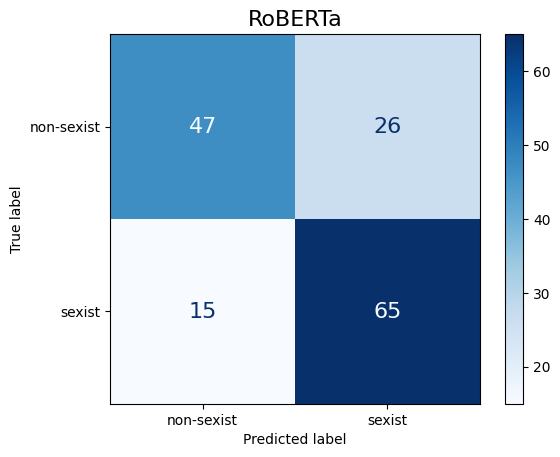

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for RoBERTa:

2025-07-15 08:10:21,237 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-07-15 08:10:22,960 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-15 08:10:23,015 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-07-15 08:10:23,017 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-15 08:10:23,073 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-15 08:10:23,128 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
cargado 29
This is a table Py

In [13]:
gold_path_dev_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_validation_{evaluation_type}.json"
gold_dev_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_validation_truth.txt"
#create file with predictions
dev_pred_json,dev_pred_txt = save_evaluation(exist_dev_df, dir+"/models/evaluation/predictions", ds_name, "validation", evaluation_type, "roberta", y_pred, "sexist", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_dev_binary,dev_pred_json,
                               y_dev,y_pred,
                                ["non-sexist","sexist"],
                               gold_dev_txt,dev_pred_txt,
                               model_name="RoBERTa")

In [ ]:
#make predictions on test data
y_pred = exist_test_df["roberta representation"].apply(lambda x: classify_text(x, sexism_id_model, sexism_id_tokenizer, device))

Saved EXIST2024 test split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_test_binary.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for RoBERTa:
              precision    recall  f1-score   support

  non-sexist       0.70      0.64      0.67        76
      sexist       0.73      0.78      0.76        95

    accuracy                           0.72       171
   macro avg       0.72      0.71      0.71       171
weighted avg       0.72      0.72      0.72       171

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Confusion matrix for RoBERTa:


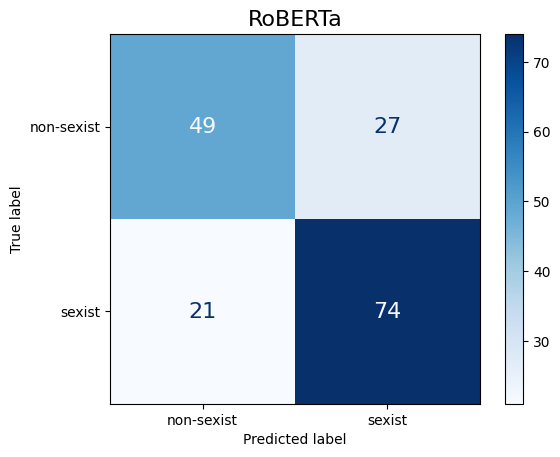

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for RoBERTa:

2025-06-24 14:50:36,246 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-06-24 14:50:36,591 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:50:36,648 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-06-24 14:50:36,650 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:50:36,705 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 14:50:36,759 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
This is a table PyEvALL repor

In [ ]:
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "roberta", y_pred, "sexist", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred,
                                ["non-sexist","sexist"],
                               gold_test_txt,test_pred_txt,
                               model_name="RoBERTa")

In [ ]:
#save predictions on test set
output_dir = os.path.join(dir, "models","output",ds_name) #creating dir for output
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/roberta_{ds_name}_test_{evaluation_type}.csv"
save_predictions_csv(exist_test_df, y_pred.to_numpy(), ["sexist"], output_path)

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/roberta_EXIST2024_test_binary.csv


## Multilabel classification: Sexism Categorization

### Flat

In [ ]:
evaluation_type = "flat"
#division and processing of data as input to the model
X_train = exist_train_df["roberta representation"].tolist()
X_dev = exist_dev_df["roberta representation"].tolist()
X_test = exist_test_df["roberta representation"].tolist()

In [ ]:
#constants
MODEL_NAME = "roberta-base"

LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
MIN_EPOCHS = 5
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 10
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1",
        disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"
CLASSES = ["ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]

#df for results
results_df = pd.DataFrame()
results_df["meme_id"] = exist_test_df["meme id"]
#results_df["meme_id"] = exist_test_df["meme id"][:100]

# Binary relevance loop
for label in CLASSES:
    print(f"{'-'*100}\nRunning Optuna tuning for label: {label}\n")

    #get labels
    y_train = exist_train_df[label].to_numpy()
    y_dev = exist_dev_df[label].to_numpy()

    #tokenize data and format as dataset dict for fine-tuning
    train_data = data_loader.load(X_train, y_train)
    dev_data = data_loader.load(X_dev, y_dev)

    # Run hyperparameter tuning with optuna
    study = optuna.create_study(study_name='hp-search-bert', direction='minimize')
    study.optimize(objective, n_trials=NUM_TRIALS)

    print(f"\nBest trial for {label}: {study.best_trial.params}\n{'-'*100}")
    print(f"{'-'*100}\nTraining model with best parameters for label: {label}\n")

    # Train best model with best params
    best_params = study.best_trial.params
    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        eval_strategy="epoch",
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        num_train_epochs=best_params['num_train_epochs'],
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        metric_for_best_model="eval_f1",
        save_strategy="no",
        report_to="none",
        #disable_tqdm=True,
    )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    final_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    final_trainer.train()

    #save model
    output_dir=f"{SAVE_DIR}-{label}"
    tokenizer.save_pretrained(f"{output_dir}/tokenizer")
    model.save_pretrained(f"{output_dir}/model")

    print(f"\nSaved tokenizer and model for {label}\n{'-'*100}")

    #predict on test set
    y_pred = exist_test_df["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))

    #save predictions
    results_df[label] = y_pred

#save all predictions
output_dir_pred = os.path.join(dir, "models","output",ds_name) #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/roberta_{ds_name}_test_{evaluation_type}.csv"
results_df.rename(columns={col: f"{col}_prediction" for col in results_df.columns[1:]}, inplace=True) #rename the columns to predictions
#add the misogynous predictions to the results
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/{ds_name}/roberta_{ds_name}_test_binary.csv")
results_df.insert(loc=1, column=binary_preds.columns[1], value=binary_preds.iloc[:, 1].to_numpy())
results_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: ideological-inequality



[I 2025-04-25 15:32:11,012] A new study created in memory with name: hp-search-bert


{'loss': 0.431, 'grad_norm': 12.250131607055664, 'learning_rate': 1.2604378647523058e-05, 'epoch': 5.747126436781609}


[I 2025-04-25 15:35:49,914] Trial 0 finished with value: 0.3789578689925972 and parameters: {'batch_size': 16, 'learning_rate': 4.453120578008146e-05, 'weight_decay': 0.005422784662533851, 'num_train_epochs': 8}. Best is trial 0 with value: 0.3789578689925972.


{'train_runtime': 218.5038, 'train_samples_per_second': 50.416, 'train_steps_per_second': 3.185, 'train_loss': 0.3789578689925972, 'epoch': 8.0}


[I 2025-04-25 15:38:20,850] Trial 1 finished with value: 0.18630511832959723 and parameters: {'batch_size': 64, 'learning_rate': 5.749953037217704e-06, 'weight_decay': 0.0013929174347696138, 'num_train_epochs': 6}. Best is trial 1 with value: 0.18630511832959723.


{'train_runtime': 150.5406, 'train_samples_per_second': 54.882, 'train_steps_per_second': 0.877, 'train_loss': 0.18630511832959723, 'epoch': 6.0}


[I 2025-04-25 15:42:13,551] Trial 2 finished with value: 0.14755505263203322 and parameters: {'batch_size': 32, 'learning_rate': 3.487120709255714e-05, 'weight_decay': 0.0003869600489821531, 'num_train_epochs': 9}. Best is trial 2 with value: 0.14755505263203322.


{'train_runtime': 232.3085, 'train_samples_per_second': 53.347, 'train_steps_per_second': 1.705, 'train_loss': 0.14755505263203322, 'epoch': 9.0}
{'loss': 0.1413, 'grad_norm': 0.0895799845457077, 'learning_rate': 1.4250142143162521e-05, 'epoch': 2.8901734104046244}
{'loss': 0.0741, 'grad_norm': 3.1469674110412598, 'learning_rate': 8.462107154063203e-06, 'epoch': 5.780346820809249}
{'loss': 0.069, 'grad_norm': 0.08099409192800522, 'learning_rate': 2.674072164963885e-06, 'epoch': 8.670520231213873}


[I 2025-04-25 15:47:11,223] Trial 3 finished with value: 0.08855926370345099 and parameters: {'batch_size': 8, 'learning_rate': 2.0026601062283642e-05, 'weight_decay': 1.0734177755112212e-06, 'num_train_epochs': 10}. Best is trial 3 with value: 0.08855926370345099.


{'train_runtime': 297.2787, 'train_samples_per_second': 46.32, 'train_steps_per_second': 5.819, 'train_loss': 0.08855926370345099, 'epoch': 10.0}
{'loss': 0.4647, 'grad_norm': 1.3530070781707764, 'learning_rate': 4.007958807704955e-05, 'epoch': 2.8901734104046244}
{'loss': 0.5656, 'grad_norm': 4.6290388107299805, 'learning_rate': 1.7435753005270142e-05, 'epoch': 5.780346820809249}


[I 2025-04-25 15:51:08,778] Trial 4 finished with value: 0.5284242244125101 and parameters: {'batch_size': 8, 'learning_rate': 6.26781354786854e-05, 'weight_decay': 8.499721763229952e-06, 'num_train_epochs': 8}. Best is trial 3 with value: 0.08855926370345099.


{'train_runtime': 237.1835, 'train_samples_per_second': 46.445, 'train_steps_per_second': 5.835, 'train_loss': 0.5284242244125101, 'epoch': 8.0}
{'loss': 0.5395, 'grad_norm': 1.627137303352356, 'learning_rate': 2.3093802352925576e-05, 'epoch': 2.8901734104046244}
{'loss': 0.5576, 'grad_norm': 4.1132636070251465, 'learning_rate': 6.876244520814919e-06, 'epoch': 5.780346820809249}


[I 2025-04-25 15:54:36,854] Trial 5 finished with value: 0.5505218820863278 and parameters: {'batch_size': 8, 'learning_rate': 3.9278925069372015e-05, 'weight_decay': 9.391727785556198e-05, 'num_train_epochs': 7}. Best is trial 3 with value: 0.08855926370345099.


{'train_runtime': 207.692, 'train_samples_per_second': 46.41, 'train_steps_per_second': 5.831, 'train_loss': 0.5505218820863278, 'epoch': 7.0}
{'loss': 0.2702, 'grad_norm': 0.31584689021110535, 'learning_rate': 1.2504881410937652e-05, 'epoch': 2.8901734104046244}
{'loss': 0.1104, 'grad_norm': 3.0905706882476807, 'learning_rate': 9.048058905873255e-07, 'epoch': 5.780346820809249}


[I 2025-04-25 15:57:35,018] Trial 6 finished with value: 0.18606503161391771 and parameters: {'batch_size': 8, 'learning_rate': 2.408175678024728e-05, 'weight_decay': 0.00012645613041872302, 'num_train_epochs': 6}. Best is trial 3 with value: 0.08855926370345099.


{'train_runtime': 177.7887, 'train_samples_per_second': 46.471, 'train_steps_per_second': 5.838, 'train_loss': 0.18606503161391771, 'epoch': 6.0}
{'loss': 0.0633, 'grad_norm': 0.10800904035568237, 'learning_rate': 2.2149965176961886e-06, 'epoch': 5.747126436781609}


[I 2025-04-25 16:01:13,612] Trial 7 finished with value: 0.05858969551393355 and parameters: {'batch_size': 16, 'learning_rate': 7.825571453383488e-06, 'weight_decay': 5.9432919011609234e-05, 'num_train_epochs': 8}. Best is trial 7 with value: 0.05858969551393355.


{'train_runtime': 218.2295, 'train_samples_per_second': 50.479, 'train_steps_per_second': 3.189, 'train_loss': 0.05858969551393355, 'epoch': 8.0}


[I 2025-04-25 16:04:34,619] Trial 8 finished with value: 0.07299017906188965 and parameters: {'batch_size': 64, 'learning_rate': 5.189302074348551e-05, 'weight_decay': 1.2132606752185545e-05, 'num_train_epochs': 8}. Best is trial 7 with value: 0.05858969551393355.


{'train_runtime': 200.63, 'train_samples_per_second': 54.907, 'train_steps_per_second': 0.877, 'train_loss': 0.07299017906188965, 'epoch': 8.0}
{'loss': 0.0425, 'grad_norm': 0.07694131135940552, 'learning_rate': 2.939225271779051e-06, 'epoch': 5.747126436781609}


[I 2025-04-25 16:08:13,156] Trial 9 finished with value: 0.040938148553344024 and parameters: {'batch_size': 16, 'learning_rate': 1.0384267965270149e-05, 'weight_decay': 0.0037550909028389026, 'num_train_epochs': 8}. Best is trial 9 with value: 0.040938148553344024.


{'train_runtime': 218.1628, 'train_samples_per_second': 50.494, 'train_steps_per_second': 3.19, 'train_loss': 0.040938148553344024, 'epoch': 8.0}

Best trial for ideological-inequality: {'batch_size': 16, 'learning_rate': 1.0384267965270149e-05, 'weight_decay': 0.0037550909028389026, 'num_train_epochs': 8}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: ideological-inequality



config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


2025-04-25 16:08:13,492 - huggingface_hub.file_download - WARNING - _download_to_tmp_and_move() - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.426691,0.382353,0.500000,0.433333
2,No log,0.368924,0.817689,0.785256,0.799351
3,No log,0.425288,0.726311,0.776709,0.741226
4,No log,0.413050,0.775492,0.825855,0.793344
5,No log,0.413298,0.783613,0.772436,0.777724
6,0.348300,0.502817,0.768293,0.735043,0.748864
7,0.348300,0.538438,0.808248,0.814103,0.811100
8,0.348300,0.567903,0.810533,0.804487,0.807432


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved tokenizer and model for ideological-inequality
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: stereotyping-dominance



[I 2025-04-25 16:12:18,207] A new study created in memory with name: hp-search-bert


{'loss': 0.4863, 'grad_norm': 45.964324951171875, 'learning_rate': 6.7093681872872445e-06, 'epoch': 2.8901734104046244}


[I 2025-04-25 16:14:46,786] Trial 0 finished with value: 0.37785767130769055 and parameters: {'batch_size': 8, 'learning_rate': 1.585684011476357e-05, 'weight_decay': 0.000639098586324755, 'num_train_epochs': 5}. Best is trial 0 with value: 0.37785767130769055.


{'train_runtime': 148.2116, 'train_samples_per_second': 46.454, 'train_steps_per_second': 5.836, 'train_loss': 0.37785767130769055, 'epoch': 5.0}
{'loss': 0.2662, 'grad_norm': 0.017587237060070038, 'learning_rate': 1.7331837265861474e-05, 'epoch': 2.8901734104046244}
{'loss': 0.1349, 'grad_norm': 0.04387912154197693, 'learning_rate': 9.14098789636172e-06, 'epoch': 5.780346820809249}
{'loss': 0.0312, 'grad_norm': 0.01487873587757349, 'learning_rate': 9.50138526861971e-07, 'epoch': 8.670520231213873}


[I 2025-04-25 16:19:13,675] Trial 1 finished with value: 0.13982755546778078 and parameters: {'batch_size': 8, 'learning_rate': 2.5506304936622224e-05, 'weight_decay': 0.0012411715703988073, 'num_train_epochs': 9}. Best is trial 1 with value: 0.13982755546778078.


{'train_runtime': 266.5255, 'train_samples_per_second': 46.498, 'train_steps_per_second': 5.842, 'train_loss': 0.13982755546778078, 'epoch': 9.0}
{'loss': 0.2012, 'grad_norm': 29.881916046142578, 'learning_rate': 2.6985653854628562e-05, 'epoch': 5.747126436781609}


[I 2025-04-25 16:23:46,896] Trial 2 finished with value: 0.12369983990987142 and parameters: {'batch_size': 16, 'learning_rate': 6.328172197716132e-05, 'weight_decay': 3.634681053784622e-05, 'num_train_epochs': 10}. Best is trial 2 with value: 0.12369983990987142.


{'train_runtime': 272.8559, 'train_samples_per_second': 50.466, 'train_steps_per_second': 3.188, 'train_loss': 0.12369983990987142, 'epoch': 10.0}


[I 2025-04-25 16:27:58,115] Trial 3 finished with value: 0.0067369043827056885 and parameters: {'batch_size': 64, 'learning_rate': 1.2135796942197415e-05, 'weight_decay': 0.001957982632158905, 'num_train_epochs': 10}. Best is trial 3 with value: 0.0067369043827056885.


{'train_runtime': 250.8475, 'train_samples_per_second': 54.894, 'train_steps_per_second': 0.877, 'train_loss': 0.0067369043827056885, 'epoch': 10.0}


[I 2025-04-25 16:31:24,981] Trial 4 finished with value: 0.028469166972420433 and parameters: {'batch_size': 32, 'learning_rate': 4.3803592666376385e-05, 'weight_decay': 7.486757571737436e-06, 'num_train_epochs': 8}. Best is trial 3 with value: 0.0067369043827056885.


{'train_runtime': 206.4794, 'train_samples_per_second': 53.352, 'train_steps_per_second': 1.705, 'train_loss': 0.028469166972420433, 'epoch': 8.0}


[I 2025-04-25 16:35:17,582] Trial 5 finished with value: 0.04513406271886344 and parameters: {'batch_size': 32, 'learning_rate': 7.491581487338415e-05, 'weight_decay': 4.5785740894854077e-05, 'num_train_epochs': 9}. Best is trial 3 with value: 0.0067369043827056885.


{'train_runtime': 232.226, 'train_samples_per_second': 53.366, 'train_steps_per_second': 1.705, 'train_loss': 0.04513406271886344, 'epoch': 9.0}


[I 2025-04-25 16:37:52,827] Trial 6 finished with value: 0.0032001848925243726 and parameters: {'batch_size': 32, 'learning_rate': 1.142883630541614e-05, 'weight_decay': 1.8360212623645718e-05, 'num_train_epochs': 6}. Best is trial 6 with value: 0.0032001848925243726.


{'train_runtime': 154.8683, 'train_samples_per_second': 53.349, 'train_steps_per_second': 1.705, 'train_loss': 0.0032001848925243726, 'epoch': 6.0}
{'loss': 0.0657, 'grad_norm': 0.0065399231389164925, 'learning_rate': 2.838887722453183e-06, 'epoch': 5.747126436781609}


[I 2025-04-25 16:40:36,765] Trial 7 finished with value: 0.06292934039200859 and parameters: {'batch_size': 16, 'learning_rate': 6.443040830958964e-05, 'weight_decay': 3.662244955730149e-05, 'num_train_epochs': 6}. Best is trial 6 with value: 0.0032001848925243726.


{'train_runtime': 163.5678, 'train_samples_per_second': 50.511, 'train_steps_per_second': 3.191, 'train_loss': 0.06292934039200859, 'epoch': 6.0}


[I 2025-04-25 16:43:32,786] Trial 8 finished with value: 0.009444211210523332 and parameters: {'batch_size': 64, 'learning_rate': 3.31847443920278e-05, 'weight_decay': 0.00022337891975230477, 'num_train_epochs': 7}. Best is trial 6 with value: 0.0032001848925243726.


{'train_runtime': 175.6467, 'train_samples_per_second': 54.877, 'train_steps_per_second': 0.877, 'train_loss': 0.009444211210523332, 'epoch': 7.0}


[I 2025-04-25 16:46:03,681] Trial 9 finished with value: 0.05718072977933017 and parameters: {'batch_size': 64, 'learning_rate': 7.559033546913449e-05, 'weight_decay': 2.9072429483841553e-05, 'num_train_epochs': 6}. Best is trial 6 with value: 0.0032001848925243726.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 150.5183, 'train_samples_per_second': 54.89, 'train_steps_per_second': 0.877, 'train_loss': 0.05718072977933017, 'epoch': 6.0}

Best trial for stereotyping-dominance: {'batch_size': 32, 'learning_rate': 1.142883630541614e-05, 'weight_decay': 1.8360212623645718e-05, 'num_train_epochs': 6}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: stereotyping-dominance



Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.563378,0.372549,0.500000,0.426966
2,No log,0.525244,0.372549,0.500000,0.426966
3,No log,0.504140,0.875000,0.512821,0.453571
4,No log,0.475379,0.600694,0.529352,0.505814
5,No log,0.469371,0.682609,0.622807,0.635907
6,No log,0.466087,0.670806,0.626856,0.638621


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for stereotyping-dominance
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: objectification



[I 2025-04-25 16:49:03,042] A new study created in memory with name: hp-search-bert
[I 2025-04-25 16:51:19,915] Trial 0 finished with value: 0.3610052700700431 and parameters: {'batch_size': 16, 'learning_rate': 1.66001764114182e-05, 'weight_decay': 0.004227041535792453, 'num_train_epochs': 5}. Best is trial 0 with value: 0.3610052700700431.


{'train_runtime': 136.4969, 'train_samples_per_second': 50.441, 'train_steps_per_second': 3.187, 'train_loss': 0.3610052700700431, 'epoch': 5.0}


[I 2025-04-25 16:55:38,441] Trial 1 finished with value: 0.06774271618236195 and parameters: {'batch_size': 32, 'learning_rate': 8.044653750866784e-06, 'weight_decay': 5.020903709325124e-05, 'num_train_epochs': 10}. Best is trial 1 with value: 0.06774271618236195.


{'train_runtime': 258.1574, 'train_samples_per_second': 53.34, 'train_steps_per_second': 1.704, 'train_loss': 0.06774271618236195, 'epoch': 10.0}
{'loss': 0.6014, 'grad_norm': 0.7465315461158752, 'learning_rate': 3.332568494237187e-05, 'epoch': 5.747126436781609}


[I 2025-04-25 17:00:11,611] Trial 2 finished with value: 0.5974903150536548 and parameters: {'batch_size': 16, 'learning_rate': 7.814918032308227e-05, 'weight_decay': 4.813921330470239e-05, 'num_train_epochs': 10}. Best is trial 1 with value: 0.06774271618236195.


{'train_runtime': 272.7794, 'train_samples_per_second': 50.48, 'train_steps_per_second': 3.189, 'train_loss': 0.5974903150536548, 'epoch': 10.0}


[I 2025-04-25 17:02:42,498] Trial 3 finished with value: 0.5868616393118193 and parameters: {'batch_size': 64, 'learning_rate': 6.115743503135336e-06, 'weight_decay': 0.0008409648857061686, 'num_train_epochs': 6}. Best is trial 1 with value: 0.06774271618236195.


{'train_runtime': 150.5235, 'train_samples_per_second': 54.888, 'train_steps_per_second': 0.877, 'train_loss': 0.5868616393118193, 'epoch': 6.0}


[I 2025-04-25 17:07:01,068] Trial 4 finished with value: 0.5882097417658025 and parameters: {'batch_size': 32, 'learning_rate': 1.3820091281495454e-05, 'weight_decay': 0.002387353652056516, 'num_train_epochs': 10}. Best is trial 1 with value: 0.06774271618236195.


{'train_runtime': 258.1871, 'train_samples_per_second': 53.333, 'train_steps_per_second': 1.704, 'train_loss': 0.5882097417658025, 'epoch': 10.0}
{'loss': 0.5923, 'grad_norm': 6.1397552490234375, 'learning_rate': 1.1319033262959257e-05, 'epoch': 2.8901734104046244}
{'loss': 0.5884, 'grad_norm': 1.2696809768676758, 'learning_rate': 8.190024067818388e-07, 'epoch': 5.780346820809249}


[I 2025-04-25 17:09:59,574] Trial 5 finished with value: 0.5898917993828511 and parameters: {'batch_size': 8, 'learning_rate': 2.1798064057424323e-05, 'weight_decay': 1.7257327282376802e-05, 'num_train_epochs': 6}. Best is trial 1 with value: 0.06774271618236195.


{'train_runtime': 178.1199, 'train_samples_per_second': 46.384, 'train_steps_per_second': 5.828, 'train_loss': 0.5898917993828511, 'epoch': 6.0}


[I 2025-04-25 17:13:52,372] Trial 6 finished with value: 0.5714267769245186 and parameters: {'batch_size': 32, 'learning_rate': 1.754654608551504e-05, 'weight_decay': 0.0018456224600760895, 'num_train_epochs': 9}. Best is trial 1 with value: 0.06774271618236195.


{'train_runtime': 232.4224, 'train_samples_per_second': 53.321, 'train_steps_per_second': 1.704, 'train_loss': 0.5714267769245186, 'epoch': 9.0}
{'loss': 0.5845, 'grad_norm': 6.229015827178955, 'learning_rate': 1.2047906175786963e-05, 'epoch': 2.8901734104046244}
{'loss': 0.5724, 'grad_norm': 1.853082299232483, 'learning_rate': 5.2411795227999785e-06, 'epoch': 5.780346820809249}


[I 2025-04-25 17:17:50,590] Trial 7 finished with value: 0.5575506177251739 and parameters: {'batch_size': 8, 'learning_rate': 1.8841019375467974e-05, 'weight_decay': 0.00018784693306644085, 'num_train_epochs': 8}. Best is trial 1 with value: 0.06774271618236195.


{'train_runtime': 237.8367, 'train_samples_per_second': 46.317, 'train_steps_per_second': 5.819, 'train_loss': 0.5575506177251739, 'epoch': 8.0}


[I 2025-04-25 17:20:07,463] Trial 8 finished with value: 0.4471207191204203 and parameters: {'batch_size': 16, 'learning_rate': 1.4908195518562276e-05, 'weight_decay': 2.804168172678091e-05, 'num_train_epochs': 5}. Best is trial 1 with value: 0.06774271618236195.


{'train_runtime': 136.4958, 'train_samples_per_second': 50.441, 'train_steps_per_second': 3.187, 'train_loss': 0.4471207191204203, 'epoch': 5.0}


[I 2025-04-25 17:22:13,276] Trial 9 finished with value: 0.4455525138161399 and parameters: {'batch_size': 64, 'learning_rate': 5.6773105062592774e-05, 'weight_decay': 0.0019779678937665805, 'num_train_epochs': 5}. Best is trial 1 with value: 0.06774271618236195.


{'train_runtime': 125.4323, 'train_samples_per_second': 54.89, 'train_steps_per_second': 0.877, 'train_loss': 0.4455525138161399, 'epoch': 5.0}

Best trial for objectification: {'batch_size': 32, 'learning_rate': 8.044653750866784e-06, 'weight_decay': 5.020903709325124e-05, 'num_train_epochs': 10}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: objectification



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.581667,0.366013,0.500000,0.422642
2,No log,0.576847,0.366013,0.500000,0.422642
3,No log,0.568624,0.366013,0.500000,0.422642
4,No log,0.554173,0.366013,0.500000,0.422642
5,No log,0.516837,0.366013,0.500000,0.422642
6,No log,0.498609,0.697090,0.646015,0.659664
7,No log,0.521748,0.662963,0.586237,0.590544
8,No log,0.498246,0.698438,0.638284,0.652273
9,No log,0.501067,0.697090,0.646015,0.659664
10,No log,0.493997,0.696060,0.661476,0.673077


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for objectification
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: sexual-violence



[I 2025-04-25 17:26:53,587] A new study created in memory with name: hp-search-bert


{'loss': 0.1711, 'grad_norm': 4.643473148345947, 'learning_rate': 1.1486867296703448e-06, 'epoch': 5.747126436781609}


[I 2025-04-25 17:29:37,737] Trial 0 finished with value: 0.1649697242568736 and parameters: {'batch_size': 16, 'learning_rate': 2.6070194473387826e-05, 'weight_decay': 2.093025915514187e-06, 'num_train_epochs': 6}. Best is trial 0 with value: 0.1649697242568736.


{'train_runtime': 163.7671, 'train_samples_per_second': 50.45, 'train_steps_per_second': 3.187, 'train_loss': 0.1649697242568736, 'epoch': 6.0}
{'loss': 0.0184, 'grad_norm': 0.0017941156402230263, 'learning_rate': 3.7356088672788534e-06, 'epoch': 5.747126436781609}


[I 2025-04-25 17:34:11,247] Trial 1 finished with value: 0.013067535148269829 and parameters: {'batch_size': 16, 'learning_rate': 8.760053138901893e-06, 'weight_decay': 0.004708928165893915, 'num_train_epochs': 10}. Best is trial 1 with value: 0.013067535148269829.


{'train_runtime': 273.1388, 'train_samples_per_second': 50.414, 'train_steps_per_second': 3.185, 'train_loss': 0.013067535148269829, 'epoch': 10.0}


[I 2025-04-25 17:37:32,458] Trial 2 finished with value: 0.05242755196311257 and parameters: {'batch_size': 64, 'learning_rate': 4.6568336893339904e-05, 'weight_decay': 6.677539461637316e-05, 'num_train_epochs': 8}. Best is trial 1 with value: 0.013067535148269829.


{'train_runtime': 200.825, 'train_samples_per_second': 54.854, 'train_steps_per_second': 0.876, 'train_loss': 0.05242755196311257, 'epoch': 8.0}
{'loss': 0.4247, 'grad_norm': 0.9611292481422424, 'learning_rate': 5.93861935044123e-05, 'epoch': 2.8901734104046244}
{'loss': 0.4064, 'grad_norm': 0.6198484301567078, 'learning_rate': 2.5834671750507047e-05, 'epoch': 5.780346820809249}


[I 2025-04-25 17:41:30,483] Trial 3 finished with value: 0.4119284084077515 and parameters: {'batch_size': 8, 'learning_rate': 9.287061221480974e-05, 'weight_decay': 4.907530639355956e-06, 'num_train_epochs': 8}. Best is trial 1 with value: 0.013067535148269829.


{'train_runtime': 237.6316, 'train_samples_per_second': 46.357, 'train_steps_per_second': 5.824, 'train_loss': 0.4119284084077515, 'epoch': 8.0}
{'loss': 0.1992, 'grad_norm': 0.015273532830178738, 'learning_rate': 1.3190925575964286e-05, 'epoch': 2.8901734104046244}
{'loss': 0.0186, 'grad_norm': 0.17750008404254913, 'learning_rate': 9.544454498378612e-07, 'epoch': 5.780346820809249}


[I 2025-04-25 17:44:28,940] Trial 4 finished with value: 0.10566961173836666 and parameters: {'batch_size': 8, 'learning_rate': 2.540293274183846e-05, 'weight_decay': 0.000840211792605358, 'num_train_epochs': 6}. Best is trial 1 with value: 0.013067535148269829.


{'train_runtime': 178.0828, 'train_samples_per_second': 46.394, 'train_steps_per_second': 5.829, 'train_loss': 0.10566961173836666, 'epoch': 6.0}
{'loss': 0.0963, 'grad_norm': 0.010178226977586746, 'learning_rate': 2.5637247800023324e-05, 'epoch': 5.747126436781609}


[I 2025-04-25 17:48:34,883] Trial 5 finished with value: 0.06384081051876414 and parameters: {'batch_size': 16, 'learning_rate': 7.068297544865585e-05, 'weight_decay': 1.0006314163195582e-06, 'num_train_epochs': 9}. Best is trial 1 with value: 0.013067535148269829.


{'train_runtime': 245.5764, 'train_samples_per_second': 50.465, 'train_steps_per_second': 3.188, 'train_loss': 0.06384081051876414, 'epoch': 9.0}


[I 2025-04-25 17:51:35,939] Trial 6 finished with value: 0.0014315188511625514 and parameters: {'batch_size': 32, 'learning_rate': 8.241822325493913e-06, 'weight_decay': 0.00013842044871977964, 'num_train_epochs': 7}. Best is trial 6 with value: 0.0014315188511625514.


{'train_runtime': 180.6806, 'train_samples_per_second': 53.348, 'train_steps_per_second': 1.705, 'train_loss': 0.0014315188511625514, 'epoch': 7.0}
{'loss': 0.0007, 'grad_norm': 4.382565020932816e-05, 'learning_rate': 2.8912884142875485e-06, 'epoch': 5.747126436781609}


[I 2025-04-25 17:56:09,156] Trial 7 finished with value: 0.0013594932597258995 and parameters: {'batch_size': 16, 'learning_rate': 6.7801102976554376e-06, 'weight_decay': 2.2754417003525338e-05, 'num_train_epochs': 10}. Best is trial 7 with value: 0.0013594932597258995.


{'train_runtime': 272.8365, 'train_samples_per_second': 50.47, 'train_steps_per_second': 3.189, 'train_loss': 0.0013594932597258995, 'epoch': 10.0}


[I 2025-04-25 17:58:44,413] Trial 8 finished with value: 6.934126510962166e-07 and parameters: {'batch_size': 32, 'learning_rate': 5.731820461437916e-06, 'weight_decay': 0.005880775654622286, 'num_train_epochs': 6}. Best is trial 8 with value: 6.934126510962166e-07.


{'train_runtime': 154.8912, 'train_samples_per_second': 53.341, 'train_steps_per_second': 1.704, 'train_loss': 6.934126510962166e-07, 'epoch': 6.0}


[I 2025-04-25 18:02:11,344] Trial 9 finished with value: 0.005645065822384574 and parameters: {'batch_size': 32, 'learning_rate': 5.584087788552593e-05, 'weight_decay': 2.0829112864029997e-06, 'num_train_epochs': 8}. Best is trial 8 with value: 6.934126510962166e-07.


{'train_runtime': 206.5598, 'train_samples_per_second': 53.331, 'train_steps_per_second': 1.704, 'train_loss': 0.005645065822384574, 'epoch': 8.0}

Best trial for sexual-violence: {'batch_size': 32, 'learning_rate': 5.731820461437916e-06, 'weight_decay': 0.005880775654622286, 'num_train_epochs': 6}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: sexual-violence



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.258951,0.464052,0.500000,0.481356
2,No log,0.252199,0.464052,0.500000,0.481356
3,No log,0.244751,0.464052,0.500000,0.481356
4,No log,0.238733,0.464052,0.500000,0.481356
5,No log,0.236033,0.464052,0.500000,0.481356
6,No log,0.237009,0.464052,0.500000,0.481356


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for sexual-violence
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: misogyny-non-sexual-violence



[I 2025-04-25 18:05:05,615] A new study created in memory with name: hp-search-bert


{'loss': 0.3342, 'grad_norm': 0.2531534731388092, 'learning_rate': 4.029107566112468e-06, 'epoch': 2.8901734104046244}


[I 2025-04-25 18:07:34,434] Trial 0 finished with value: 0.2817876738619942 and parameters: {'batch_size': 8, 'learning_rate': 9.522344384391489e-06, 'weight_decay': 1.128199281507385e-05, 'num_train_epochs': 5}. Best is trial 0 with value: 0.2817876738619942.


{'train_runtime': 148.4368, 'train_samples_per_second': 46.383, 'train_steps_per_second': 5.827, 'train_loss': 0.2817876738619942, 'epoch': 5.0}


[I 2025-04-25 18:10:35,495] Trial 1 finished with value: 0.07251686244815975 and parameters: {'batch_size': 32, 'learning_rate': 7.338748372345331e-06, 'weight_decay': 0.0017776950385089353, 'num_train_epochs': 7}. Best is trial 1 with value: 0.07251686244815975.


{'train_runtime': 180.6868, 'train_samples_per_second': 53.346, 'train_steps_per_second': 1.705, 'train_loss': 0.07251686244815975, 'epoch': 7.0}


[I 2025-04-25 18:14:21,684] Trial 2 finished with value: 0.01999160617288917 and parameters: {'batch_size': 64, 'learning_rate': 1.263835261484377e-05, 'weight_decay': 0.0008992946572182669, 'num_train_epochs': 9}. Best is trial 2 with value: 0.01999160617288917.


{'train_runtime': 225.815, 'train_samples_per_second': 54.881, 'train_steps_per_second': 0.877, 'train_loss': 0.01999160617288917, 'epoch': 9.0}
{'loss': 0.2719, 'grad_norm': 0.020845822989940643, 'learning_rate': 2.729897645447867e-05, 'epoch': 2.8901734104046244}
{'loss': 0.0258, 'grad_norm': 0.0046949139796197414, 'learning_rate': 1.9752506154446534e-06, 'epoch': 5.780346820809249}


[I 2025-04-25 18:17:20,071] Trial 3 finished with value: 0.1434068226198054 and parameters: {'batch_size': 8, 'learning_rate': 5.257205484183462e-05, 'weight_decay': 0.00012229960851360057, 'num_train_epochs': 6}. Best is trial 2 with value: 0.01999160617288917.


{'train_runtime': 178.0104, 'train_samples_per_second': 46.413, 'train_steps_per_second': 5.831, 'train_loss': 0.1434068226198054, 'epoch': 6.0}


[I 2025-04-25 18:21:06,246] Trial 4 finished with value: 0.0038087118153620246 and parameters: {'batch_size': 64, 'learning_rate': 9.84633033292213e-06, 'weight_decay': 0.0008323667267064119, 'num_train_epochs': 9}. Best is trial 4 with value: 0.0038087118153620246.


{'train_runtime': 225.8129, 'train_samples_per_second': 54.882, 'train_steps_per_second': 0.877, 'train_loss': 0.0038087118153620246, 'epoch': 9.0}
{'loss': 0.1077, 'grad_norm': 0.0013749821810051799, 'learning_rate': 3.442897810491394e-05, 'epoch': 5.747126436781609}


[I 2025-04-25 18:25:12,339] Trial 5 finished with value: 0.0699903384174576 and parameters: {'batch_size': 16, 'learning_rate': 9.492214738080146e-05, 'weight_decay': 0.00010367705694728116, 'num_train_epochs': 9}. Best is trial 4 with value: 0.0038087118153620246.


{'train_runtime': 245.717, 'train_samples_per_second': 50.436, 'train_steps_per_second': 3.187, 'train_loss': 0.0699903384174576, 'epoch': 9.0}
{'loss': 0.1522, 'grad_norm': 11.038641929626465, 'learning_rate': 4.5750258462889546e-05, 'epoch': 2.8901734104046244}
{'loss': 0.3785, 'grad_norm': 6.786200046539307, 'learning_rate': 3.3103155474075927e-06, 'epoch': 5.780346820809249}


[I 2025-04-25 18:28:10,696] Trial 6 finished with value: 0.26902466242942735 and parameters: {'batch_size': 8, 'learning_rate': 8.810532149254054e-05, 'weight_decay': 3.871182602068836e-05, 'num_train_epochs': 6}. Best is trial 4 with value: 0.0038087118153620246.


{'train_runtime': 177.9902, 'train_samples_per_second': 46.418, 'train_steps_per_second': 5.832, 'train_loss': 0.26902466242942735, 'epoch': 6.0}


[I 2025-04-25 18:32:29,249] Trial 7 finished with value: 0.291942665793679 and parameters: {'batch_size': 32, 'learning_rate': 9.418116123943973e-05, 'weight_decay': 0.0014098199820263436, 'num_train_epochs': 10}. Best is trial 4 with value: 0.0038087118153620246.


{'train_runtime': 258.1709, 'train_samples_per_second': 53.337, 'train_steps_per_second': 1.704, 'train_loss': 0.291942665793679, 'epoch': 10.0}


[I 2025-04-25 18:36:15,403] Trial 8 finished with value: 0.1265772906216708 and parameters: {'batch_size': 64, 'learning_rate': 5.715315377217991e-05, 'weight_decay': 6.139764780938271e-06, 'num_train_epochs': 9}. Best is trial 4 with value: 0.0038087118153620246.


{'train_runtime': 225.7685, 'train_samples_per_second': 54.893, 'train_steps_per_second': 0.877, 'train_loss': 0.1265772906216708, 'epoch': 9.0}


[I 2025-04-25 18:40:01,580] Trial 9 finished with value: 0.05921118187181877 and parameters: {'batch_size': 64, 'learning_rate': 4.418630863854545e-05, 'weight_decay': 0.000110533427742309, 'num_train_epochs': 9}. Best is trial 4 with value: 0.0038087118153620246.


{'train_runtime': 225.8, 'train_samples_per_second': 54.885, 'train_steps_per_second': 0.877, 'train_loss': 0.05921118187181877, 'epoch': 9.0}

Best trial for misogyny-non-sexual-violence: {'batch_size': 64, 'learning_rate': 9.84633033292213e-06, 'weight_decay': 0.0008323667267064119, 'num_train_epochs': 9}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: misogyny-non-sexual-violence



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.354814,0.444444,0.500000,0.470588
2,No log,0.340479,0.444444,0.500000,0.470588
3,No log,0.317143,0.444444,0.500000,0.470588
4,No log,0.312817,0.444444,0.500000,0.470588
5,No log,0.314752,0.444444,0.500000,0.470588
6,No log,0.308844,0.444444,0.500000,0.470588
7,No log,0.316472,0.444079,0.496324,0.468750
8,No log,0.313529,0.666341,0.573529,0.593085
9,No log,0.327765,0.444079,0.496324,0.468750


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for misogyny-non-sexual-violence
----------------------------------------------------------------------------------------------------
Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/roberta_EXIST2024_test_flat.csv


In [ ]:
#evaluation on test results
evaluation_type = "flat"
flat_labels = ["sexist","ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]
prediction_cols = [f"{label}_prediction" for label in flat_labels]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/roberta_EXIST2024_test_flat.csv") #load results file
y_pred = results_df[prediction_cols].to_numpy() #get predictions
y_test = exist_test_df[flat_labels] #get gold labels

In [ ]:
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "roberta", y_pred, "sexist", flat_labels)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test_binary,test_pred_json,
                                   y_test,y_pred,
                                   flat_labels,
                                   gold_test_txt,test_pred_txt,
                                   hierarchy=False)

Saved EXIST2024 test split flat evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_test_flat.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                              precision    recall  f1-score   support

                  non-sexist       0.70      0.64      0.67        76
      ideological-inequality       0.60      0.54      0.57        39
      stereotyping-dominance       0.46      0.30      0.36        40
             objectification       0.54      0.44      0.49        43
             sexual-violence       0.00      0.00      0.00        16
misogyny-non-sexual-violence       0.00      0.00      0.00        16

                   micro avg       0.59      0.44      0.50       230
                   

In [ ]:
#let's run hyperparameter tuning again, this time with a fixed 10 epochs

#constants
MODEL_NAME = "roberta-base"

LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
#MIN_EPOCHS = 5
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 10
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        #num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        num_train_epochs=MAX_EPOCHS,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1",
        disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"
CLASSES = ["ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]

#df for results
results_df = pd.DataFrame()
results_df["meme_id"] = exist_test_df["meme id"]
#results_df["meme_id"] = exist_test_df["meme id"][:100]

# Binary relevance loop
for label in CLASSES:
    print(f"{'-'*100}\nRunning Optuna tuning for label: {label}\n")

    #get labels
    y_train = exist_train_df[label].to_numpy()
    y_dev = exist_dev_df[label].to_numpy()

    #tokenize data and format as dataset dict for fine-tuning
    train_data = data_loader.load(X_train, y_train)
    dev_data = data_loader.load(X_dev, y_dev)

    # Run hyperparameter tuning with optuna
    study = optuna.create_study(study_name='hp-search-bert', direction='minimize')
    study.optimize(objective, n_trials=NUM_TRIALS)

    print(f"\nBest trial for {label}: {study.best_trial.params}\n{'-'*100}")
    print(f"{'-'*100}\nTraining model with best parameters for label: {label}\n")

    # Train best model with best params
    best_params = study.best_trial.params
    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}-10e",
        eval_strategy="epoch",
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        num_train_epochs=10,
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        metric_for_best_model="eval_f1",
        save_strategy="no",
        report_to="none",
        #disable_tqdm=True,
    )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    final_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    final_trainer.train()

    #save model
    output_dir=f"{SAVE_DIR}-{label}-10e"
    tokenizer.save_pretrained(f"{output_dir}/tokenizer")
    model.save_pretrained(f"{output_dir}/model")

    print(f"\nSaved tokenizer and model for {label}\n{'-'*100}")

    #predict on test set
    y_pred = exist_test_df["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))

    #save predictions
    results_df[label] = y_pred

#save all predictions
output_dir_pred = os.path.join(dir, "models","output",ds_name) #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/roberta_{ds_name}_test_{evaluation_type}_10e.csv"
results_df.rename(columns={col: f"{col}_prediction" for col in results_df.columns[1:]}, inplace=True) #rename the columns to predictions
#add the misogynous predictions to the results
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/{ds_name}/roberta_{ds_name}_test_binary.csv")
results_df.insert(loc=1, column=binary_preds.columns[1], value=binary_preds.iloc[:, 1].to_numpy())
results_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: ideological-inequality



[I 2025-04-29 10:50:21,477] A new study created in memory with name: hp-search-bert


{'loss': 0.5674, 'grad_norm': 1.0834096670150757, 'learning_rate': 3.1748769790050146e-05, 'epoch': 2.8901734104046244}
{'loss': 0.5635, 'grad_norm': 5.21398401260376, 'learning_rate': 1.8853249972808007e-05, 'epoch': 5.780346820809249}
{'loss': 0.5108, 'grad_norm': 2.942976474761963, 'learning_rate': 5.957730155565867e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 10:55:20,456] Trial 0 finished with value: 0.5356320860757993 and parameters: {'batch_size': 8, 'learning_rate': 4.46184985676578e-05, 'weight_decay': 1.3089987664194454e-05}. Best is trial 0 with value: 0.5356320860757993.


{'train_runtime': 296.7283, 'train_samples_per_second': 46.406, 'train_steps_per_second': 5.83, 'train_loss': 0.5356320860757993, 'epoch': 10.0}
{'loss': 0.4727, 'grad_norm': 0.776561439037323, 'learning_rate': 2.5786547426327244e-05, 'epoch': 2.8901734104046244}
{'loss': 0.4483, 'grad_norm': 4.512433052062988, 'learning_rate': 1.531272637582877e-05, 'epoch': 5.780346820809249}
{'loss': 0.4192, 'grad_norm': 2.05782151222229, 'learning_rate': 4.838905325330295e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 11:00:19,333] Trial 1 finished with value: 0.4403831614235233 and parameters: {'batch_size': 8, 'learning_rate': 3.6239420834724724e-05, 'weight_decay': 1.0719583166027449e-06}. Best is trial 1 with value: 0.4403831614235233.


{'train_runtime': 298.5062, 'train_samples_per_second': 46.13, 'train_steps_per_second': 5.796, 'train_loss': 0.4403831614235233, 'epoch': 10.0}
{'loss': 0.3828, 'grad_norm': 2.242177724838257, 'learning_rate': 1.6150191540784193e-05, 'epoch': 2.8901734104046244}
{'loss': 0.3273, 'grad_norm': 9.139604568481445, 'learning_rate': 9.590406187094432e-06, 'epoch': 5.780346820809249}
{'loss': 0.2794, 'grad_norm': 4.032786846160889, 'learning_rate': 3.0306208334046695e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 11:05:15,551] Trial 2 finished with value: 0.3181647504685242 and parameters: {'batch_size': 8, 'learning_rate': 2.2696857323766576e-05, 'weight_decay': 0.00047087923481629803}. Best is trial 2 with value: 0.3181647504685242.


{'train_runtime': 295.8542, 'train_samples_per_second': 46.543, 'train_steps_per_second': 5.847, 'train_loss': 0.3181647504685242, 'epoch': 10.0}
{'loss': 0.2612, 'grad_norm': 1.1474494934082031, 'learning_rate': 1.6643648247592507e-05, 'epoch': 5.747126436781609}


[I 2025-04-29 11:09:48,617] Trial 3 finished with value: 0.22819550612877154 and parameters: {'batch_size': 16, 'learning_rate': 3.902957944853229e-05, 'weight_decay': 3.324655346598797e-05}. Best is trial 3 with value: 0.22819550612877154.


{'train_runtime': 272.6902, 'train_samples_per_second': 50.497, 'train_steps_per_second': 3.19, 'train_loss': 0.22819550612877154, 'epoch': 10.0}
{'loss': 0.3876, 'grad_norm': 2.5771090984344482, 'learning_rate': 2.610626686509133e-05, 'epoch': 2.8901734104046244}
{'loss': 0.3297, 'grad_norm': 3.886267900466919, 'learning_rate': 1.550258414165862e-05, 'epoch': 5.780346820809249}
{'loss': 0.2739, 'grad_norm': 2.7040903568267822, 'learning_rate': 4.898901418225911e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 11:14:45,160] Trial 4 finished with value: 0.32007855101127847 and parameters: {'batch_size': 8, 'learning_rate': 3.6688742223077173e-05, 'weight_decay': 9.802073277627927e-05}. Best is trial 3 with value: 0.22819550612877154.


{'train_runtime': 296.1551, 'train_samples_per_second': 46.496, 'train_steps_per_second': 5.842, 'train_loss': 0.32007855101127847, 'epoch': 10.0}


[I 2025-04-29 11:18:57,018] Trial 5 finished with value: 0.23010324998335405 and parameters: {'batch_size': 64, 'learning_rate': 5.307047592178461e-06, 'weight_decay': 0.002185492133740715}. Best is trial 3 with value: 0.22819550612877154.


{'train_runtime': 251.4726, 'train_samples_per_second': 54.757, 'train_steps_per_second': 0.875, 'train_loss': 0.23010324998335405, 'epoch': 10.0}
{'loss': 0.5157, 'grad_norm': 2.1921164989471436, 'learning_rate': 3.997863619827255e-05, 'epoch': 2.8901734104046244}
{'loss': 0.5597, 'grad_norm': 3.8553755283355713, 'learning_rate': 2.3740359919526596e-05, 'epoch': 5.780346820809249}
{'loss': 0.4526, 'grad_norm': 3.4570019245147705, 'learning_rate': 7.502083640780634e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 11:23:53,153] Trial 6 finished with value: 0.4834523283677294 and parameters: {'batch_size': 8, 'learning_rate': 5.618443592446103e-05, 'weight_decay': 0.0015418777021811373}. Best is trial 3 with value: 0.22819550612877154.


{'train_runtime': 295.7569, 'train_samples_per_second': 46.559, 'train_steps_per_second': 5.849, 'train_loss': 0.4834523283677294, 'epoch': 10.0}


[I 2025-04-29 11:28:12,107] Trial 7 finished with value: 0.31876269253817474 and parameters: {'batch_size': 32, 'learning_rate': 1.3832647976140615e-05, 'weight_decay': 1.6911803301618384e-05}. Best is trial 3 with value: 0.22819550612877154.


{'train_runtime': 258.5781, 'train_samples_per_second': 53.253, 'train_steps_per_second': 1.702, 'train_loss': 0.31876269253817474, 'epoch': 10.0}


[I 2025-04-29 11:32:31,040] Trial 8 finished with value: 0.23302900140935726 and parameters: {'batch_size': 32, 'learning_rate': 1.2829462327141642e-05, 'weight_decay': 0.0018221937682431511}. Best is trial 3 with value: 0.22819550612877154.


{'train_runtime': 258.5451, 'train_samples_per_second': 53.26, 'train_steps_per_second': 1.702, 'train_loss': 0.23302900140935726, 'epoch': 10.0}


[I 2025-04-29 11:36:42,886] Trial 9 finished with value: 0.22009223591197621 and parameters: {'batch_size': 64, 'learning_rate': 2.0133145086911698e-05, 'weight_decay': 2.326659355224939e-05}. Best is trial 9 with value: 0.22009223591197621.


{'train_runtime': 251.4633, 'train_samples_per_second': 54.759, 'train_steps_per_second': 0.875, 'train_loss': 0.22009223591197621, 'epoch': 10.0}

Best trial for ideological-inequality: {'batch_size': 64, 'learning_rate': 2.0133145086911698e-05, 'weight_decay': 2.326659355224939e-05}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: ideological-inequality



config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.513017,0.382353,0.500000,0.433333
2,No log,0.406971,0.763889,0.763889,0.763889
3,No log,0.360238,0.794318,0.776709,0.784810
4,No log,0.369067,0.782051,0.782051,0.782051
5,No log,0.396602,0.764479,0.792735,0.776316
6,No log,0.423342,0.802521,0.790598,0.796247
7,No log,0.445341,0.772430,0.797009,0.783077
8,No log,0.481875,0.772267,0.787393,0.779221
9,No log,0.492387,0.785899,0.762821,0.773109
10,No log,0.499807,0.794318,0.776709,0.784810


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved tokenizer and model for ideological-inequality
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: stereotyping-dominance



[I 2025-04-29 11:41:23,568] A new study created in memory with name: hp-search-bert


{'loss': 0.3455, 'grad_norm': 34.90486526489258, 'learning_rate': 8.337775974849807e-06, 'epoch': 5.747126436781609}


[I 2025-04-29 11:45:56,721] Trial 0 finished with value: 0.21767763378976404 and parameters: {'batch_size': 16, 'learning_rate': 1.9552197029971245e-05, 'weight_decay': 0.0007110253072663278}. Best is trial 0 with value: 0.21767763378976404.


{'train_runtime': 272.7688, 'train_samples_per_second': 50.482, 'train_steps_per_second': 3.19, 'train_loss': 0.21767763378976404, 'epoch': 10.0}


[I 2025-04-29 11:50:15,574] Trial 1 finished with value: 0.05728483200073242 and parameters: {'batch_size': 32, 'learning_rate': 2.827949937102752e-05, 'weight_decay': 3.236987758834861e-05}. Best is trial 1 with value: 0.05728483200073242.


{'train_runtime': 258.4744, 'train_samples_per_second': 53.274, 'train_steps_per_second': 1.702, 'train_loss': 0.05728483200073242, 'epoch': 10.0}
{'loss': 0.3078, 'grad_norm': 0.013880578801035881, 'learning_rate': 3.0592789980207045e-05, 'epoch': 2.8901734104046244}
{'loss': 0.1011, 'grad_norm': 0.004801526200026274, 'learning_rate': 1.8166798924070958e-05, 'epoch': 5.780346820809249}
{'loss': 0.0131, 'grad_norm': 0.0016995620680972934, 'learning_rate': 5.740807867934871e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 11:55:11,242] Trial 2 finished with value: 0.12197439895910507 and parameters: {'batch_size': 8, 'learning_rate': 4.299392905423086e-05, 'weight_decay': 0.0026010919389969794}. Best is trial 1 with value: 0.05728483200073242.


{'train_runtime': 295.3017, 'train_samples_per_second': 46.63, 'train_steps_per_second': 5.858, 'train_loss': 0.12197439895910507, 'epoch': 10.0}


[I 2025-04-29 11:59:30,139] Trial 3 finished with value: 0.010170576789162375 and parameters: {'batch_size': 32, 'learning_rate': 1.5747376117633387e-05, 'weight_decay': 1.073639575362081e-06}. Best is trial 3 with value: 0.010170576789162375.


{'train_runtime': 258.5322, 'train_samples_per_second': 53.262, 'train_steps_per_second': 1.702, 'train_loss': 0.010170576789162375, 'epoch': 10.0}
{'loss': 0.0682, 'grad_norm': 0.011781953275203705, 'learning_rate': 2.02518661870018e-05, 'epoch': 5.747126436781609}


[I 2025-04-29 12:04:03,234] Trial 4 finished with value: 0.04261777291352722 and parameters: {'batch_size': 16, 'learning_rate': 4.7490899144721204e-05, 'weight_decay': 4.512163012013491e-05}. Best is trial 3 with value: 0.010170576789162375.


{'train_runtime': 272.7255, 'train_samples_per_second': 50.49, 'train_steps_per_second': 3.19, 'train_loss': 0.04261777291352722, 'epoch': 10.0}


[I 2025-04-29 12:08:15,118] Trial 5 finished with value: 0.008503855900330978 and parameters: {'batch_size': 64, 'learning_rate': 3.312229914640671e-05, 'weight_decay': 2.2068607442705367e-06}. Best is trial 5 with value: 0.008503855900330978.


{'train_runtime': 251.5203, 'train_samples_per_second': 54.747, 'train_steps_per_second': 0.875, 'train_loss': 0.008503855900330978, 'epoch': 10.0}


[I 2025-04-29 12:12:27,038] Trial 6 finished with value: 0.0006489317525516857 and parameters: {'batch_size': 64, 'learning_rate': 1.2242182672807911e-05, 'weight_decay': 0.0020796381335920207}. Best is trial 6 with value: 0.0006489317525516857.


{'train_runtime': 251.5439, 'train_samples_per_second': 54.742, 'train_steps_per_second': 0.875, 'train_loss': 0.0006489317525516857, 'epoch': 10.0}
{'loss': 0.0107, 'grad_norm': 2.678467171790544e-05, 'learning_rate': 4.202345152788727e-06, 'epoch': 5.747126436781609}


[I 2025-04-29 12:17:00,566] Trial 7 finished with value: 0.009429939039822283 and parameters: {'batch_size': 16, 'learning_rate': 9.854556018668984e-06, 'weight_decay': 2.767339514308231e-06}. Best is trial 6 with value: 0.0006489317525516857.


{'train_runtime': 273.1349, 'train_samples_per_second': 50.415, 'train_steps_per_second': 3.185, 'train_loss': 0.009429939039822283, 'epoch': 10.0}


[I 2025-04-29 12:21:19,471] Trial 8 finished with value: 0.0044760831377723 and parameters: {'batch_size': 32, 'learning_rate': 1.136451974620287e-05, 'weight_decay': 0.006530138442752852}. Best is trial 6 with value: 0.0006489317525516857.


{'train_runtime': 258.5111, 'train_samples_per_second': 53.267, 'train_steps_per_second': 1.702, 'train_loss': 0.0044760831377723, 'epoch': 10.0}


[I 2025-04-29 12:25:38,336] Trial 9 finished with value: 0.044125387885353785 and parameters: {'batch_size': 32, 'learning_rate': 8.137978362691818e-05, 'weight_decay': 6.864321568352123e-05}. Best is trial 6 with value: 0.0006489317525516857.


{'train_runtime': 258.5002, 'train_samples_per_second': 53.269, 'train_steps_per_second': 1.702, 'train_loss': 0.044125387885353785, 'epoch': 10.0}

Best trial for stereotyping-dominance: {'batch_size': 64, 'learning_rate': 1.2242182672807911e-05, 'weight_decay': 0.0020796381335920207}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: stereotyping-dominance



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.562951,0.372549,0.500000,0.426966
2,No log,0.561644,0.372549,0.500000,0.426966
3,No log,0.536349,0.372549,0.500000,0.426966
4,No log,0.497237,0.372549,0.500000,0.426966
5,No log,0.470074,0.616586,0.575574,0.580261
6,No log,0.467406,0.643130,0.592780,0.600736
7,No log,0.484924,0.640117,0.651147,0.644551
8,No log,0.481334,0.630021,0.638327,0.633493
9,No log,0.488550,0.652510,0.659919,0.655802
10,No log,0.485733,0.649637,0.639001,0.643523


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for stereotyping-dominance
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: objectification



[I 2025-04-29 12:30:13,528] A new study created in memory with name: hp-search-bert
[I 2025-04-29 12:34:25,473] Trial 0 finished with value: 0.26600086905739523 and parameters: {'batch_size': 64, 'learning_rate': 1.7824175957881807e-05, 'weight_decay': 0.0011590921126228759}. Best is trial 0 with value: 0.26600086905739523.


{'train_runtime': 251.5638, 'train_samples_per_second': 54.738, 'train_steps_per_second': 0.875, 'train_loss': 0.26600086905739523, 'epoch': 10.0}


[I 2025-04-29 12:38:37,386] Trial 1 finished with value: 0.05878342281688343 and parameters: {'batch_size': 64, 'learning_rate': 1.7433783856678432e-05, 'weight_decay': 0.0004252658371001972}. Best is trial 1 with value: 0.05878342281688343.


{'train_runtime': 251.539, 'train_samples_per_second': 54.743, 'train_steps_per_second': 0.875, 'train_loss': 0.05878342281688343, 'epoch': 10.0}
{'loss': 0.6022, 'grad_norm': 0.8161353468894958, 'learning_rate': 3.552952116033862e-05, 'epoch': 5.747126436781609}


[I 2025-04-29 12:43:10,667] Trial 2 finished with value: 0.5976190852022719 and parameters: {'batch_size': 16, 'learning_rate': 8.331720595551104e-05, 'weight_decay': 4.940528691123743e-06}. Best is trial 1 with value: 0.05878342281688343.


{'train_runtime': 272.9114, 'train_samples_per_second': 50.456, 'train_steps_per_second': 3.188, 'train_loss': 0.5976190852022719, 'epoch': 10.0}
{'loss': 0.4314, 'grad_norm': 13.569852828979492, 'learning_rate': 5.880974693146457e-06, 'epoch': 5.747126436781609}


[I 2025-04-29 12:47:44,099] Trial 3 finished with value: 0.3451257201446884 and parameters: {'batch_size': 16, 'learning_rate': 1.3790964913847486e-05, 'weight_decay': 1.571901788208506e-06}. Best is trial 1 with value: 0.05878342281688343.


{'train_runtime': 273.0567, 'train_samples_per_second': 50.429, 'train_steps_per_second': 3.186, 'train_loss': 0.3451257201446884, 'epoch': 10.0}
{'loss': 0.3095, 'grad_norm': 5.408476829528809, 'learning_rate': 5.13561240390095e-06, 'epoch': 2.8901734104046244}
{'loss': 0.169, 'grad_norm': 0.1310262680053711, 'learning_rate': 3.0496609807080375e-06, 'epoch': 5.780346820809249}
{'loss': 0.1403, 'grad_norm': 0.16767266392707825, 'learning_rate': 9.637095575151254e-07, 'epoch': 8.670520231213873}


[I 2025-04-29 12:52:41,179] Trial 4 finished with value: 0.19485898651828656 and parameters: {'batch_size': 8, 'learning_rate': 7.217391924247476e-06, 'weight_decay': 0.0014189336716414077}. Best is trial 1 with value: 0.05878342281688343.


{'train_runtime': 296.7064, 'train_samples_per_second': 46.41, 'train_steps_per_second': 5.831, 'train_loss': 0.19485898651828656, 'epoch': 10.0}


[I 2025-04-29 12:57:00,264] Trial 5 finished with value: 0.07033943262967196 and parameters: {'batch_size': 32, 'learning_rate': 9.517634622573231e-06, 'weight_decay': 0.004141761917798525}. Best is trial 1 with value: 0.05878342281688343.


{'train_runtime': 258.7042, 'train_samples_per_second': 53.227, 'train_steps_per_second': 1.701, 'train_loss': 0.07033943262967196, 'epoch': 10.0}
{'loss': 0.5969, 'grad_norm': 6.410922527313232, 'learning_rate': 5.7688104522426834e-05, 'epoch': 2.8901734104046244}
{'loss': 0.5943, 'grad_norm': 1.1499017477035522, 'learning_rate': 3.425670544751748e-05, 'epoch': 5.780346820809249}
{'loss': 0.5981, 'grad_norm': 1.770385503768921, 'learning_rate': 1.0825306372608122e-05, 'epoch': 8.670520231213873}


[I 2025-04-29 13:01:57,644] Trial 6 finished with value: 0.5943916894107885 and parameters: {'batch_size': 8, 'learning_rate': 8.107264079918638e-05, 'weight_decay': 0.0014104646211061246}. Best is trial 1 with value: 0.05878342281688343.


{'train_runtime': 296.9939, 'train_samples_per_second': 46.365, 'train_steps_per_second': 5.825, 'train_loss': 0.5943916894107885, 'epoch': 10.0}


[I 2025-04-29 13:06:09,649] Trial 7 finished with value: 0.33124965320933947 and parameters: {'batch_size': 64, 'learning_rate': 1.7547380754773013e-05, 'weight_decay': 8.626739473986367e-05}. Best is trial 1 with value: 0.05878342281688343.


{'train_runtime': 251.6305, 'train_samples_per_second': 54.723, 'train_steps_per_second': 0.874, 'train_loss': 0.33124965320933947, 'epoch': 10.0}
{'loss': 0.241, 'grad_norm': 0.23263461887836456, 'learning_rate': 1.0211594459710265e-05, 'epoch': 2.8901734104046244}
{'loss': 0.1106, 'grad_norm': 0.05386718362569809, 'learning_rate': 6.06391190093274e-06, 'epoch': 5.780346820809249}
{'loss': 0.0637, 'grad_norm': 0.030826151371002197, 'learning_rate': 1.916229342155216e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 13:11:07,120] Trial 8 finished with value: 0.12652303111346472 and parameters: {'batch_size': 8, 'learning_rate': 1.4350981653370234e-05, 'weight_decay': 0.0033298356330109333}. Best is trial 1 with value: 0.05878342281688343.


{'train_runtime': 297.0832, 'train_samples_per_second': 46.351, 'train_steps_per_second': 5.823, 'train_loss': 0.12652303111346472, 'epoch': 10.0}
{'loss': 0.0711, 'grad_norm': 0.06574345380067825, 'learning_rate': 1.0285526293745293e-05, 'epoch': 5.747126436781609}


[I 2025-04-29 13:15:40,717] Trial 9 finished with value: 0.05356451670328776 and parameters: {'batch_size': 16, 'learning_rate': 2.4119697777785457e-05, 'weight_decay': 0.0016133285490492293}. Best is trial 9 with value: 0.05356451670328776.


{'train_runtime': 273.2203, 'train_samples_per_second': 50.399, 'train_steps_per_second': 3.184, 'train_loss': 0.05356451670328776, 'epoch': 10.0}

Best trial for objectification: {'batch_size': 16, 'learning_rate': 2.4119697777785457e-05, 'weight_decay': 0.0016133285490492293}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: objectification



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.595867,0.366013,0.500000,0.422642
2,No log,0.546770,0.654823,0.683145,0.660386
3,No log,0.495305,0.707571,0.658210,0.672537
4,No log,0.546260,0.661929,0.651350,0.655870
5,No log,0.893614,0.672577,0.714068,0.673774
6,0.382800,0.966783,0.707854,0.704595,0.706173
7,0.382800,1.379096,0.712869,0.764046,0.717271
8,0.382800,1.280237,0.664305,0.659081,0.661504
9,0.382800,1.320889,0.669872,0.655814,0.661600
10,0.382800,1.373000,0.690929,0.687936,0.689383


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved tokenizer and model for objectification
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: sexual-violence



[I 2025-04-29 13:20:28,611] A new study created in memory with name: hp-search-bert


{'loss': 0.4285, 'grad_norm': 2.1160998344421387, 'learning_rate': 4.414931993132947e-05, 'epoch': 2.8901734104046244}
{'loss': 0.3809, 'grad_norm': 0.405389666557312, 'learning_rate': 2.6217021015273634e-05, 'epoch': 5.780346820809249}
{'loss': 0.1671, 'grad_norm': 3.5349457263946533, 'learning_rate': 8.284722099217796e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 13:25:25,424] Trial 0 finished with value: 0.2986166540597905 and parameters: {'batch_size': 8, 'learning_rate': 6.20457542495532e-05, 'weight_decay': 0.0003076521890935014}. Best is trial 0 with value: 0.2986166540597905.


{'train_runtime': 296.444, 'train_samples_per_second': 46.451, 'train_steps_per_second': 5.836, 'train_loss': 0.2986166540597905, 'epoch': 10.0}
{'loss': 0.2709, 'grad_norm': 1.0060118436813354, 'learning_rate': 3.425063492994485e-05, 'epoch': 5.747126436781609}


[I 2025-04-29 13:29:58,985] Trial 1 finished with value: 0.22046181251262797 and parameters: {'batch_size': 16, 'learning_rate': 8.031820050957418e-05, 'weight_decay': 1.1141020856298399e-05}. Best is trial 1 with value: 0.22046181251262797.


{'train_runtime': 273.1798, 'train_samples_per_second': 50.406, 'train_steps_per_second': 3.185, 'train_loss': 0.22046181251262797, 'epoch': 10.0}


[I 2025-04-29 13:34:10,954] Trial 2 finished with value: 0.14724625674161043 and parameters: {'batch_size': 64, 'learning_rate': 7.624726620245783e-05, 'weight_decay': 2.6857628228920952e-05}. Best is trial 2 with value: 0.14724625674161043.


{'train_runtime': 251.5879, 'train_samples_per_second': 54.732, 'train_steps_per_second': 0.874, 'train_loss': 0.14724625674161043, 'epoch': 10.0}
{'loss': 0.1213, 'grad_norm': 0.4253578782081604, 'learning_rate': 1.5688076343096974e-05, 'epoch': 5.747126436781609}


[I 2025-04-29 13:38:44,677] Trial 3 finished with value: 0.11310751904016253 and parameters: {'batch_size': 16, 'learning_rate': 3.6788750454162714e-05, 'weight_decay': 0.009091512924292701}. Best is trial 3 with value: 0.11310751904016253.


{'train_runtime': 273.3309, 'train_samples_per_second': 50.378, 'train_steps_per_second': 3.183, 'train_loss': 0.11310751904016253, 'epoch': 10.0}
{'loss': 0.1034, 'grad_norm': 0.1459772288799286, 'learning_rate': 5.27083057772099e-06, 'epoch': 2.8901734104046244}
{'loss': 0.118, 'grad_norm': 0.1438044309616089, 'learning_rate': 3.129957069304666e-06, 'epoch': 5.780346820809249}
{'loss': 0.104, 'grad_norm': 0.1391831636428833, 'learning_rate': 9.890835608883417e-07, 'epoch': 8.670520231213873}


[I 2025-04-29 13:43:41,743] Trial 4 finished with value: 0.10468361253683278 and parameters: {'batch_size': 8, 'learning_rate': 7.407422339120482e-06, 'weight_decay': 0.0011472349007608088}. Best is trial 4 with value: 0.10468361253683278.


{'train_runtime': 296.6887, 'train_samples_per_second': 46.412, 'train_steps_per_second': 5.831, 'train_loss': 0.10468361253683278, 'epoch': 10.0}
{'loss': 0.0823, 'grad_norm': 0.056405581533908844, 'learning_rate': 7.0607914535818104e-06, 'epoch': 2.8901734104046244}
{'loss': 0.058, 'grad_norm': 0.04495292156934738, 'learning_rate': 4.192882658463285e-06, 'epoch': 5.780346820809249}
{'loss': 0.0569, 'grad_norm': 0.05025767907500267, 'learning_rate': 1.324973863344759e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 13:48:38,561] Trial 5 finished with value: 0.06556749895128901 and parameters: {'batch_size': 8, 'learning_rate': 9.9229644311101e-06, 'weight_decay': 3.232150047237618e-05}. Best is trial 5 with value: 0.06556749895128901.


{'train_runtime': 296.4329, 'train_samples_per_second': 46.452, 'train_steps_per_second': 5.836, 'train_loss': 0.06556749895128901, 'epoch': 10.0}
{'loss': 0.0494, 'grad_norm': 0.07016316056251526, 'learning_rate': 5.381665844078393e-06, 'epoch': 5.747126436781609}


[I 2025-04-29 13:53:12,236] Trial 6 finished with value: 0.045605842546484934 and parameters: {'batch_size': 16, 'learning_rate': 1.2620078933553103e-05, 'weight_decay': 0.00030321685508050963}. Best is trial 6 with value: 0.045605842546484934.


{'train_runtime': 273.2981, 'train_samples_per_second': 50.385, 'train_steps_per_second': 3.183, 'train_loss': 0.045605842546484934, 'epoch': 10.0}


[I 2025-04-29 13:57:31,317] Trial 7 finished with value: 0.06031552661548961 and parameters: {'batch_size': 32, 'learning_rate': 5.493441654461589e-05, 'weight_decay': 0.006759294651210442}. Best is trial 6 with value: 0.045605842546484934.


{'train_runtime': 258.7059, 'train_samples_per_second': 53.226, 'train_steps_per_second': 1.701, 'train_loss': 0.06031552661548961, 'epoch': 10.0}
{'loss': 0.0726, 'grad_norm': 0.06749612092971802, 'learning_rate': 2.0512113012523343e-05, 'epoch': 2.8901734104046244}
{'loss': 0.062, 'grad_norm': 0.0501457154750824, 'learning_rate': 1.2180629254390387e-05, 'epoch': 5.780346820809249}
{'loss': 0.0499, 'grad_norm': 0.058025676757097244, 'learning_rate': 3.849145496257427e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 14:02:28,723] Trial 8 finished with value: 0.06004523569448835 and parameters: {'batch_size': 8, 'learning_rate': 2.882693380314004e-05, 'weight_decay': 0.0004677533618479141}. Best is trial 6 with value: 0.045605842546484934.


{'train_runtime': 297.0236, 'train_samples_per_second': 46.36, 'train_steps_per_second': 5.824, 'train_loss': 0.06004523569448835, 'epoch': 10.0}
{'loss': 0.0584, 'grad_norm': 0.0649285539984703, 'learning_rate': 1.2986358405609985e-05, 'epoch': 2.8901734104046244}
{'loss': 0.0615, 'grad_norm': 0.06113563850522041, 'learning_rate': 7.711639313160763e-06, 'epoch': 5.780346820809249}
{'loss': 0.059, 'grad_norm': 0.08292244374752045, 'learning_rate': 2.4369202207115407e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 14:07:25,904] Trial 9 finished with value: 0.059601298646430746 and parameters: {'batch_size': 8, 'learning_rate': 1.825052805987431e-05, 'weight_decay': 7.160746608282734e-06}. Best is trial 6 with value: 0.045605842546484934.


{'train_runtime': 296.7938, 'train_samples_per_second': 46.396, 'train_steps_per_second': 5.829, 'train_loss': 0.059601298646430746, 'epoch': 10.0}

Best trial for sexual-violence: {'batch_size': 16, 'learning_rate': 1.2620078933553103e-05, 'weight_decay': 0.00030321685508050963}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: sexual-violence



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.261099,0.464052,0.500000,0.481356
2,No log,0.289051,0.464052,0.500000,0.481356
3,No log,0.230502,0.464052,0.500000,0.481356
4,No log,0.195633,0.675524,0.660691,0.667669
5,No log,0.414829,0.613757,0.747759,0.639434
6,0.310000,0.609761,0.600407,0.737196,0.619788
7,0.310000,0.480261,0.639238,0.726953,0.667391
8,0.310000,0.509723,0.648148,0.730474,0.676211
9,0.310000,0.566966,0.659962,0.772407,0.694897
10,0.310000,0.539486,0.669285,0.775928,0.704348


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for sexual-violence
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Optuna tuning for label: misogyny-non-sexual-violence



[I 2025-04-29 14:12:13,873] A new study created in memory with name: hp-search-bert
[I 2025-04-29 14:16:25,915] Trial 0 finished with value: 0.2281760822642933 and parameters: {'batch_size': 64, 'learning_rate': 5.782593092019455e-05, 'weight_decay': 0.0008091903013324369}. Best is trial 0 with value: 0.2281760822642933.


{'train_runtime': 251.6722, 'train_samples_per_second': 54.714, 'train_steps_per_second': 0.874, 'train_loss': 0.2281760822642933, 'epoch': 10.0}


[I 2025-04-29 14:20:37,897] Trial 1 finished with value: 0.08616668527776544 and parameters: {'batch_size': 64, 'learning_rate': 5.273626165317721e-05, 'weight_decay': 2.6722503260736023e-06}. Best is trial 1 with value: 0.08616668527776544.


{'train_runtime': 251.6024, 'train_samples_per_second': 54.729, 'train_steps_per_second': 0.874, 'train_loss': 0.08616668527776544, 'epoch': 10.0}
{'loss': 0.3337, 'grad_norm': 0.785646378993988, 'learning_rate': 4.0229734881169674e-05, 'epoch': 2.8901734104046244}
{'loss': 0.3503, 'grad_norm': 5.683469295501709, 'learning_rate': 2.3889468885568672e-05, 'epoch': 5.780346820809249}
{'loss': 0.3489, 'grad_norm': 1.3178746700286865, 'learning_rate': 7.549202889967664e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 14:25:34,921] Trial 2 finished with value: 0.3460840655200054 and parameters: {'batch_size': 8, 'learning_rate': 5.653732034477948e-05, 'weight_decay': 0.0021371823028643877}. Best is trial 1 with value: 0.08616668527776544.


{'train_runtime': 296.6485, 'train_samples_per_second': 46.419, 'train_steps_per_second': 5.832, 'train_loss': 0.3460840655200054, 'epoch': 10.0}
{'loss': 0.2116, 'grad_norm': 0.07781139761209488, 'learning_rate': 4.116653250035716e-06, 'epoch': 2.8901734104046244}
{'loss': 0.0618, 'grad_norm': 0.0785975530743599, 'learning_rate': 2.444576381621534e-06, 'epoch': 5.780346820809249}
{'loss': 0.0323, 'grad_norm': 0.01813473179936409, 'learning_rate': 7.724995132073521e-07, 'epoch': 8.670520231213873}


[I 2025-04-29 14:30:32,087] Trial 3 finished with value: 0.09158158219618605 and parameters: {'batch_size': 8, 'learning_rate': 5.7853859647130705e-06, 'weight_decay': 1.728794360831468e-05}. Best is trial 1 with value: 0.08616668527776544.


{'train_runtime': 296.7938, 'train_samples_per_second': 46.396, 'train_steps_per_second': 5.829, 'train_loss': 0.09158158219618605, 'epoch': 10.0}
{'loss': 0.0497, 'grad_norm': 0.01072519551962614, 'learning_rate': 5.2222298512578865e-06, 'epoch': 2.8901734104046244}
{'loss': 0.0102, 'grad_norm': 0.007885802537202835, 'learning_rate': 3.101096686652734e-06, 'epoch': 5.780346820809249}
{'loss': 0.0091, 'grad_norm': 0.005917823873460293, 'learning_rate': 9.799635220475808e-07, 'epoch': 8.670520231213873}


[I 2025-04-29 14:35:29,324] Trial 4 finished with value: 0.021001024397811447 and parameters: {'batch_size': 8, 'learning_rate': 7.33912074953383e-06, 'weight_decay': 0.0004378090703674078}. Best is trial 4 with value: 0.021001024397811447.


{'train_runtime': 296.8478, 'train_samples_per_second': 46.387, 'train_steps_per_second': 5.828, 'train_loss': 0.021001024397811447, 'epoch': 10.0}
{'loss': 0.0339, 'grad_norm': 0.017813662067055702, 'learning_rate': 4.558423129179507e-06, 'epoch': 5.747126436781609}


[I 2025-04-29 14:40:03,151] Trial 5 finished with value: 0.02354129155476888 and parameters: {'batch_size': 16, 'learning_rate': 1.0689563672199923e-05, 'weight_decay': 0.0013917411358038063}. Best is trial 4 with value: 0.021001024397811447.


{'train_runtime': 273.4538, 'train_samples_per_second': 50.356, 'train_steps_per_second': 3.182, 'train_loss': 0.02354129155476888, 'epoch': 10.0}
{'loss': 0.3028, 'grad_norm': 0.8925033211708069, 'learning_rate': 4.1640672770273845e-05, 'epoch': 2.8901734104046244}
{'loss': 0.3451, 'grad_norm': 5.769754886627197, 'learning_rate': 2.4727320710861238e-05, 'epoch': 5.780346820809249}
{'loss': 0.3453, 'grad_norm': 1.4372494220733643, 'learning_rate': 7.813968651448626e-06, 'epoch': 8.670520231213873}


[I 2025-04-29 14:45:00,349] Trial 6 finished with value: 0.3343233185696464 and parameters: {'batch_size': 8, 'learning_rate': 5.852019812556764e-05, 'weight_decay': 0.004231340625679476}. Best is trial 4 with value: 0.021001024397811447.


{'train_runtime': 296.8308, 'train_samples_per_second': 46.39, 'train_steps_per_second': 5.828, 'train_loss': 0.3343233185696464, 'epoch': 10.0}


[I 2025-04-29 14:49:19,453] Trial 7 finished with value: 0.21078352494673294 and parameters: {'batch_size': 32, 'learning_rate': 6.773324288532632e-06, 'weight_decay': 0.006409784958511676}. Best is trial 4 with value: 0.021001024397811447.


{'train_runtime': 258.7407, 'train_samples_per_second': 53.219, 'train_steps_per_second': 1.701, 'train_loss': 0.21078352494673294, 'epoch': 10.0}
{'loss': 0.0362, 'grad_norm': 0.020137902349233627, 'learning_rate': 8.296425098958946e-06, 'epoch': 5.747126436781609}


[I 2025-04-29 14:53:53,174] Trial 8 finished with value: 0.02640964354591808 and parameters: {'batch_size': 16, 'learning_rate': 1.9455228668717746e-05, 'weight_decay': 0.001663807756650789}. Best is trial 4 with value: 0.021001024397811447.


{'train_runtime': 273.3516, 'train_samples_per_second': 50.375, 'train_steps_per_second': 3.183, 'train_loss': 0.02640964354591808, 'epoch': 10.0}


[I 2025-04-29 14:58:12,358] Trial 9 finished with value: 0.30292001204057173 and parameters: {'batch_size': 32, 'learning_rate': 8.042826150127187e-05, 'weight_decay': 0.0013575456238885944}. Best is trial 4 with value: 0.021001024397811447.


{'train_runtime': 258.8055, 'train_samples_per_second': 53.206, 'train_steps_per_second': 1.7, 'train_loss': 0.30292001204057173, 'epoch': 10.0}

Best trial for misogyny-non-sexual-violence: {'batch_size': 8, 'learning_rate': 7.33912074953383e-06, 'weight_decay': 0.0004378090703674078}
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training model with best parameters for label: misogyny-non-sexual-violence



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.345527,0.444444,0.500000,0.470588
2,No log,0.391719,0.444444,0.500000,0.470588
3,0.366000,0.295879,0.444444,0.500000,0.470588
4,0.366000,0.393593,0.444079,0.496324,0.468750
5,0.366000,0.517000,0.545946,0.514706,0.510243
6,0.265500,0.523459,0.685019,0.625000,0.646197
7,0.265500,0.573933,0.710993,0.654412,0.676211
8,0.265500,0.572906,0.710993,0.654412,0.676211
9,0.130000,0.602706,0.691484,0.650735,0.667391
10,0.130000,0.623425,0.674717,0.647059,0.659003


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for misogyny-non-sexual-violence
----------------------------------------------------------------------------------------------------
Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/roberta_EXIST2024_test_flat_10e.csv


In [ ]:
#evaluation on test results
evaluation_type = "flat"
flat_labels = ["sexist","ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]
prediction_cols = [f"{label}_prediction" for label in flat_labels]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/roberta_EXIST2024_test_flat_10e.csv") #load results file
y_pred = results_df[prediction_cols].to_numpy() #get predictions
y_test = exist_test_df[flat_labels] #get gold labels

In [ ]:
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "roberta", y_pred, "sexist", flat_labels)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test_binary,test_pred_json,
                                   y_test,y_pred,
                                   flat_labels,
                                   gold_test_txt,test_pred_txt,
                                   hierarchy=False)

Saved EXIST2024 test split flat evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_test_flat.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                              precision    recall  f1-score   support

                  non-sexist       0.70      0.64      0.67        76
      ideological-inequality       0.62      0.54      0.58        39
      stereotyping-dominance       0.42      0.42      0.42        40
             objectification       0.63      0.51      0.56        43
             sexual-violence       0.37      0.44      0.40        16
misogyny-non-sexual-violence       0.36      0.31      0.33        16

                   micro avg       0.57      0.53      0.55       230
                   

In [ ]:
#update the predictions file
results_df.to_csv("/content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/roberta_EXIST2024_test_flat.csv", index=False)

### Hierarchical

In [ ]:
evaluation_type = "hierarchical"
binary_label = "sexist"
train_bin_pos = exist_train_df[exist_train_df[binary_label] == 1] #only the instances with positive class in binary level
dev_positive = exist_dev_df[exist_dev_df[binary_label] == 1]

In [ ]:
#division and processing of data as input to the model
X_train = train_bin_pos["roberta representation"].tolist()
X_dev = dev_positive["roberta representation"].tolist()
#X_test = exist_test_df["roberta representation"].tolist()

In [ ]:
#constants
MODEL_NAME = "roberta-base"

LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
#MIN_EPOCHS = 5
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 10
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        #num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        num_train_epochs=MAX_EPOCHS,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1",
        disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
#after doing hyperparameter tuning with optuna, these were the best parameters found:

best_parameters = {
    "ideological-inequality": {'batch_size': 64,
                               'learning_rate': 7.589406983366415e-06,
                               'weight_decay': 0.0014773945795869903,
                               'epoch': 10},
    "stereotyping-dominance": {'batch_size': 32,
                               'learning_rate': 8.068473659506592e-06,
                               'weight_decay': 7.056054004068002e-05,
                               'epoch': 10},
    "objectification": {'batch_size': 64,
                        'learning_rate': 2.4941463833292925e-05,
                        'weight_decay': 4.819660192405095e-06,
                        'epoch': 10},

    "sexual-violence": {'batch_size': 64,
                        'learning_rate': 1.4501425656894979e-05,
                        'weight_decay': 0.004950969803663806,
                        'epoch': 10},
    "misogyny-non-sexual-violence": {'batch_size': 8,
                                     'learning_rate': 2.36977155448894e-05,
                                     'weight_decay': 3.018586927815049e-05,
                                     'epoch': 6}
}

In [ ]:
model, tokenizer, device = load_model(model_name="FacebookAI/roberta-base")
data_loader = DataLoader(tokenizer, device=device)

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"

# Binary relevance loop
for label, params in best_parameters.items():
    print(f"{'-'*100}\nFine-tuning model for label: {label}")

    #get labels
    y_train = train_bin_pos[label].to_numpy()
    y_dev = dev_positive[label].to_numpy()

    #tokenize data and format as dataset dict for fine-tuning
    train_data = data_loader.load(X_train, y_train)
    dev_data = data_loader.load(X_dev, y_dev)

    # Train model with best params
    training_args = TrainingArguments(
        output_dir=f"{SAVE_DIR}-{label}",
        eval_strategy="epoch",
        learning_rate=params['learning_rate'],
        weight_decay=params['weight_decay'],
        num_train_epochs=params['epoch'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=params['batch_size'],
        metric_for_best_model="eval_f1",
        save_strategy="no",
        report_to="none",
        #disable_tqdm=True,
    )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

    final_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    final_trainer.train()

    #save model
    output_dir=f"{SAVE_DIR}-{label}"
    tokenizer.save_pretrained(f"{output_dir}/tokenizer")
    model.save_pretrained(f"{output_dir}/model")

    print(f"\nSaved tokenizer and model for {label}\n{'-'*100}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------------------------------------
Fine-tuning model for label: ideological-inequality


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.687978,0.275000,0.500000,0.354839
2,No log,0.683916,0.275000,0.500000,0.354839
3,No log,0.678511,0.275000,0.500000,0.354839
4,No log,0.664100,0.275000,0.500000,0.354839
5,No log,0.607790,0.748082,0.744949,0.746032
6,No log,0.532604,0.761767,0.756313,0.757923
7,No log,0.493688,0.760317,0.758838,0.759456
8,No log,0.484469,0.786429,0.789141,0.786667
9,No log,0.480075,0.773657,0.770202,0.771429
10,No log,0.478689,0.785355,0.786616,0.785860


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for ideological-inequality
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fine-tuning model for label: stereotyping-dominance


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.694031,0.243750,0.500000,0.327731
2,No log,0.693259,0.567708,0.565041,0.559125
3,No log,0.692807,0.493243,0.498124,0.382414
4,No log,0.689259,0.563283,0.563164,0.562432
5,No log,0.676333,0.588346,0.588180,0.587436
6,No log,0.684508,0.591432,0.589431,0.585882
7,No log,0.682496,0.576367,0.575985,0.574734
8,No log,0.680913,0.599750,0.599750,0.599750
9,No log,0.688831,0.587500,0.587555,0.587436
10,No log,0.690522,0.612500,0.612570,0.612439


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved tokenizer and model for stereotyping-dominance
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fine-tuning model for label: objectification


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.689677,0.243750,0.500000,0.327731
2,No log,0.668963,0.687500,0.620075,0.577585
3,No log,0.544412,0.786702,0.772358,0.771429
4,No log,0.520821,0.699812,0.699812,0.699812
5,No log,0.483810,0.700189,0.699187,0.699248
6,No log,0.495057,0.750469,0.750469,0.750000
7,No log,0.552506,0.792627,0.777986,0.772727
8,No log,0.460480,0.787594,0.787054,0.787201
9,No log,0.494332,0.787500,0.787680,0.787467
10,No log,0.501956,0.799875,0.799875,0.799875


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved tokenizer and model for objectification
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fine-tuning model for label: sexual-violence


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.392195,0.431250,0.500000,0.463087
2,No log,0.435691,0.431250,0.500000,0.463087
3,No log,0.358162,0.431250,0.500000,0.463087
4,No log,0.351856,0.431250,0.500000,0.463087
5,No log,0.297259,0.431250,0.500000,0.463087
6,No log,0.319293,0.840278,0.758235,0.790967
7,No log,0.282694,0.789196,0.789196,0.789196
8,No log,0.288784,0.743590,0.812912,0.770379
9,No log,0.300468,0.743590,0.812912,0.770379
10,No log,0.295582,0.743590,0.812912,0.770379


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for sexual-violence
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fine-tuning model for label: misogyny-non-sexual-violence


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.522651,0.393750,0.500000,0.440559
2,No log,0.509746,0.393750,0.500000,0.440559
3,No log,0.459237,0.392405,0.492063,0.436620
4,No log,0.691167,0.618395,0.556489,0.558824
5,No log,0.945396,0.664286,0.607376,0.621275
6,0.399100,1.005710,0.648680,0.620915,0.630769


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Saved tokenizer and model for misogyny-non-sexual-violence
----------------------------------------------------------------------------------------------------


In [ ]:
## Evaluation: hierarchical

#load first-level binary predictions
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/{ds_name}/roberta_{ds_name}_test_binary.csv")
y_pred_binary = binary_preds["sexist_prediction"].to_numpy()

In [ ]:
CLASSES = ["ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = exist_test_df.copy()
test_positive["sexist_prediction"] = y_pred_binary
test_positive = test_positive[test_positive["sexist_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":exist_test_df["meme id"], "sexist_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in CLASSES]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#loading fine-tuned model and tokenizer
results_df = pd.DataFrame()
evaluation_type = "hierarchical"

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"

CLASSES = ["ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]
for label in CLASSES:
    model_dir=f"{SAVE_DIR}-{label}"
    model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
    tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Predict on test set
    y_pred = test_positive["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))
    results_df[label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

In [ ]:
#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output",ds_name) #creating dir for output
output_path = f"{output_dir_pred}/roberta_{ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/roberta_EXIST2024_test_hierarchical.csv


In [ ]:
#evaluation on test results
labels = ["sexist","ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]
prediction_cols = [f"{label}_prediction" for label in labels]
results_df = pd.read_csv(output_path) #load results file
y_pred = results_df[prediction_cols] #get predictions
y_test = exist_test_df[labels] #get gold labels

In [ ]:
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True)
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "roberta", y_pred, "sexist", labels)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test_binary,test_pred_json,
                                   y_test,y_pred.to_numpy(),
                                   labels,
                                   gold_test_txt,test_pred_txt,
                                   hierarchy=True)

<ipython-input-19-617a4ec58470>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True)


Saved EXIST2024 test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_test_hierarchical.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                              precision    recall  f1-score   support

                  non-sexist       0.70      0.64      0.67        76
      ideological-inequality       0.54      0.56      0.55        39
      stereotyping-dominance       0.43      0.57      0.49        40
             objectification       0.54      0.63      0.58        43
             sexual-violence       0.32      0.38      0.34        16
misogyny-non-sexual-violence       0.22      0.25      0.24        16

                   micro avg       0.52      0.57      0.54       230
   

### Hierarchical predictions after step 1 w/ensemble

In [ ]:
## Evaluation: hierarchical
evaluation_type = "hierarchical"
#load first-level binary predictions from ensemble
binary_preds = pd.read_csv(f"/content/drive/MyDrive/Colab/thesis/models/output/{ds_name}/ensemble_svm_roberta_robertaswin_{ds_name}_test_binary.csv")
y_pred_binary = binary_preds["sexist_prediction"].to_numpy()

In [ ]:
CLASSES = ["ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]

#filter only misogynous/sexist instances for fine-grained classification
test_positive = exist_test_df.copy()
test_positive["sexist_prediction"] = y_pred_binary
test_positive = test_positive[test_positive["sexist_prediction"] == 1] #this only applies to those that were labelled as 1 in binary

#initialize df with predictions for binary classification which will be populated with the categories
#default all fine-grained labels to 0
pred_df = pd.DataFrame({"meme_id":exist_test_df["meme id"], "sexist_prediction": y_pred_binary})
columns=[f"{label}_prediction" for label in CLASSES]#rename the columns to predictions
pred_df[columns] = 0

In [ ]:
#loading fine-tuned model and tokenizer
results_df = pd.DataFrame()
evaluation_type = "hierarchical"

MODEL_NAME = "roberta-base"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/roberta/{MODEL_NAME}"

CLASSES = ["ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]
for label in CLASSES:
    model_dir=f"{SAVE_DIR}-{label}"
    model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
    tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Predict on test set
    y_pred = test_positive["roberta representation"].apply(lambda x: classify_text(x, model, tokenizer, device))
    results_df[label] = y_pred

#add fine-grained labels to the positive instances in the predictions df to get the labels for full dataset
pred_df.loc[y_pred_binary == 1, columns] = results_df.to_numpy()

In [ ]:
#save the results file with the final predictions
output_dir_pred = os.path.join(dir, "models","output",ds_name,"ensemble_first_step") #creating dir for output
os.makedirs(output_dir_pred, exist_ok=True)
output_path = f"{output_dir_pred}/roberta_{ds_name}_test_{evaluation_type}.csv"
pred_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/ensemble_first_step/roberta_EXIST2024_test_hierarchical.csv


In [ ]:
#evaluation on test results
labels = ["sexist","ideological-inequality","stereotyping-dominance","objectification", "sexual-violence", "misogyny-non-sexual-violence"]
prediction_cols = [f"{label}_prediction" for label in labels]
results_df = pd.read_csv("/content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/ensemble_first_step/roberta_EXIST2024_test_hierarchical.csv") #load results file
y_pred = results_df[prediction_cols] #get predictions
y_test = exist_test_df[labels] #get gold labels

In [ ]:
y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True)
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "roberta_after_ensemble", y_pred, "sexist", labels)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test_binary,test_pred_json,
                                   y_test,y_pred.to_numpy(),
                                   labels,
                                   gold_test_txt,test_pred_txt,
                                   hierarchy=True)

Saved EXIST2024 test split hierarchical evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_after_ensemble_EXIST2024_test_hierarchical.json


/tmp/ipython-input-30-2692661283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred.rename(columns={col: col.replace('_prediction', '') for col in y_pred.columns if col.endswith('_prediction')}, inplace=True)


Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/roberta_after_ensemble_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                              precision    recall  f1-score   support

                  non-sexist       0.73      0.68      0.71        76
      ideological-inequality       0.56      0.59      0.57        39
      stereotyping-dominance       0.43      0.55      0.48        40
             objectification       0.59      0.67      0.63        43
             sexual-violence       0.32      0.38      0.34        16
misogyny-non-sexual-violence       0.22      0.25      0.24        16

                   micro avg       0.55      0.59      0.57       230
                   macro avg       0.48      0.52      0.50       230
                weighted avg       0.56      0.59      0.57       230
                 sa